# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

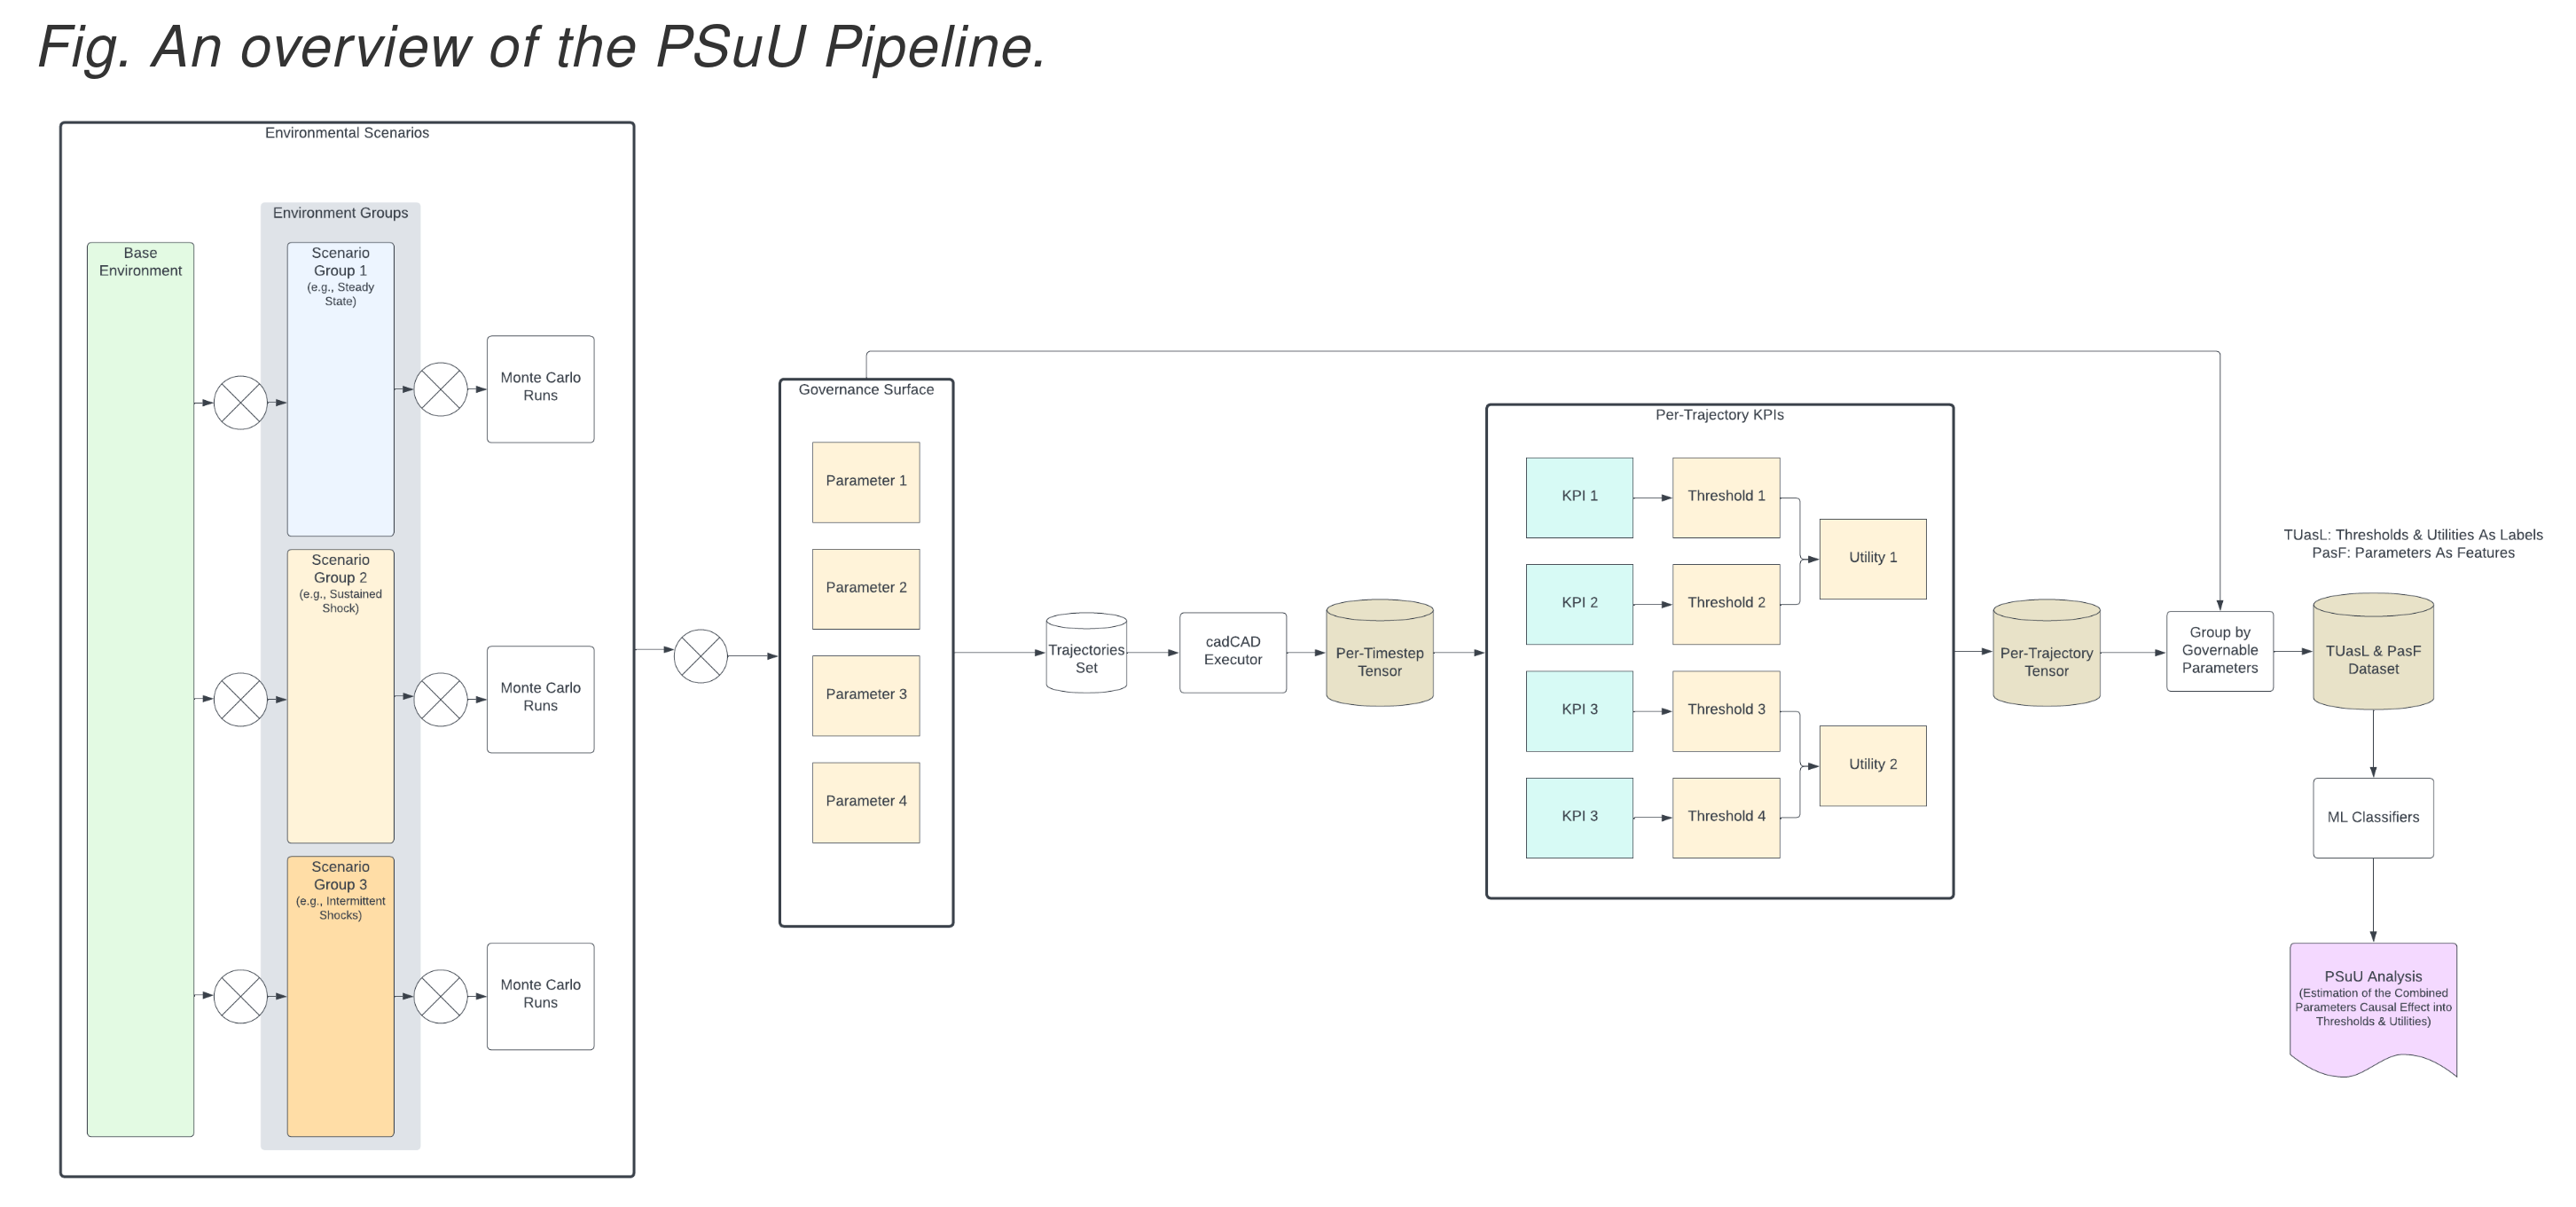

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union
from tqdm.auto import tqdm

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [2]:
pd.set_option('display.max_columns', None)

lastest_folder = sorted(glob("../../data/simulations/psuu_run-*"))[-1]
files = [f for f in os.listdir(lastest_folder) if 'timestep_tensor' in f]

sim_df = pd.read_pickle(f"{lastest_folder}/{files[0]}", compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=438,800 over N_trajectories=400 | (N_sweeps=20, N_runs=20, N_timesteps=1,097)	


In [3]:
glob("../../data/")

['../../data/']

In [4]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [5]:
traj_tensors = []
for file in tqdm(files):
    filepath = f"{lastest_folder}/{file}"
    _df = pd.read_pickle(filepath, compression='gzip')
    traj_tensors.append(timestep_tensor_to_trajectory_tensor(_df))

agg_df = pd.concat(traj_tensors).reset_index()

agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

  0%|          | 0/5 [00:00<?, ?it/s]

simulation  mean_relative_community_owned_supply  \
count       100.0                            100.000000   
mean          0.0                              0.732974   
std           0.0                              0.017458   
min           0.0                              0.697101   
25%           0.0                              0.721546   
50%           0.0                              0.738601   
75%           0.0                              0.742980   
max           0.0                              0.768947   

       mean_farmer_subsidy_factor  \
count                  100.000000   
mean                     0.997622   
std                      0.002140   
min                      0.984969   
25%                      0.996992   
50%                      0.998256   
75%                      0.999013   
max                      0.999695   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    1.000000e+02   
mean                                     6.819052e-13   
std                                      3.023794e-13   
min                                      1.343276e-13   
25%                                      4.987659e-13   
50%                                      6.910151e-13   
75%                                      9.208634e-13   
max                                      1.343171e-12   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                               100.000000             1.000000e+02   
mean                              93751.429478             7.737682e+07   
std                               41572.490234             3.278015e+07   
min                               18467.966741             1.578240e+07   
25%                               68572.615979             5.256000e+07   
50%                               95003.901194             8.409600e+07   
75%                              126604.484805             9.466560e+07   
max                              184665.232239             1.471680e+08   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                                 100.000000  1.000000e+02  
mean                               128567.993321  1.869915e+08  
std                                 78223.440062  8.291822e+07  
min                                 23877.622970  3.683520e+07  
25%                                 60627.362321  1.367712e+08  
50%                                105072.987853  1.894896e+08  
75%                                196371.486999  2.525184e+08  
max                                354101.991907  3.683232e+08

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [6]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [7]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

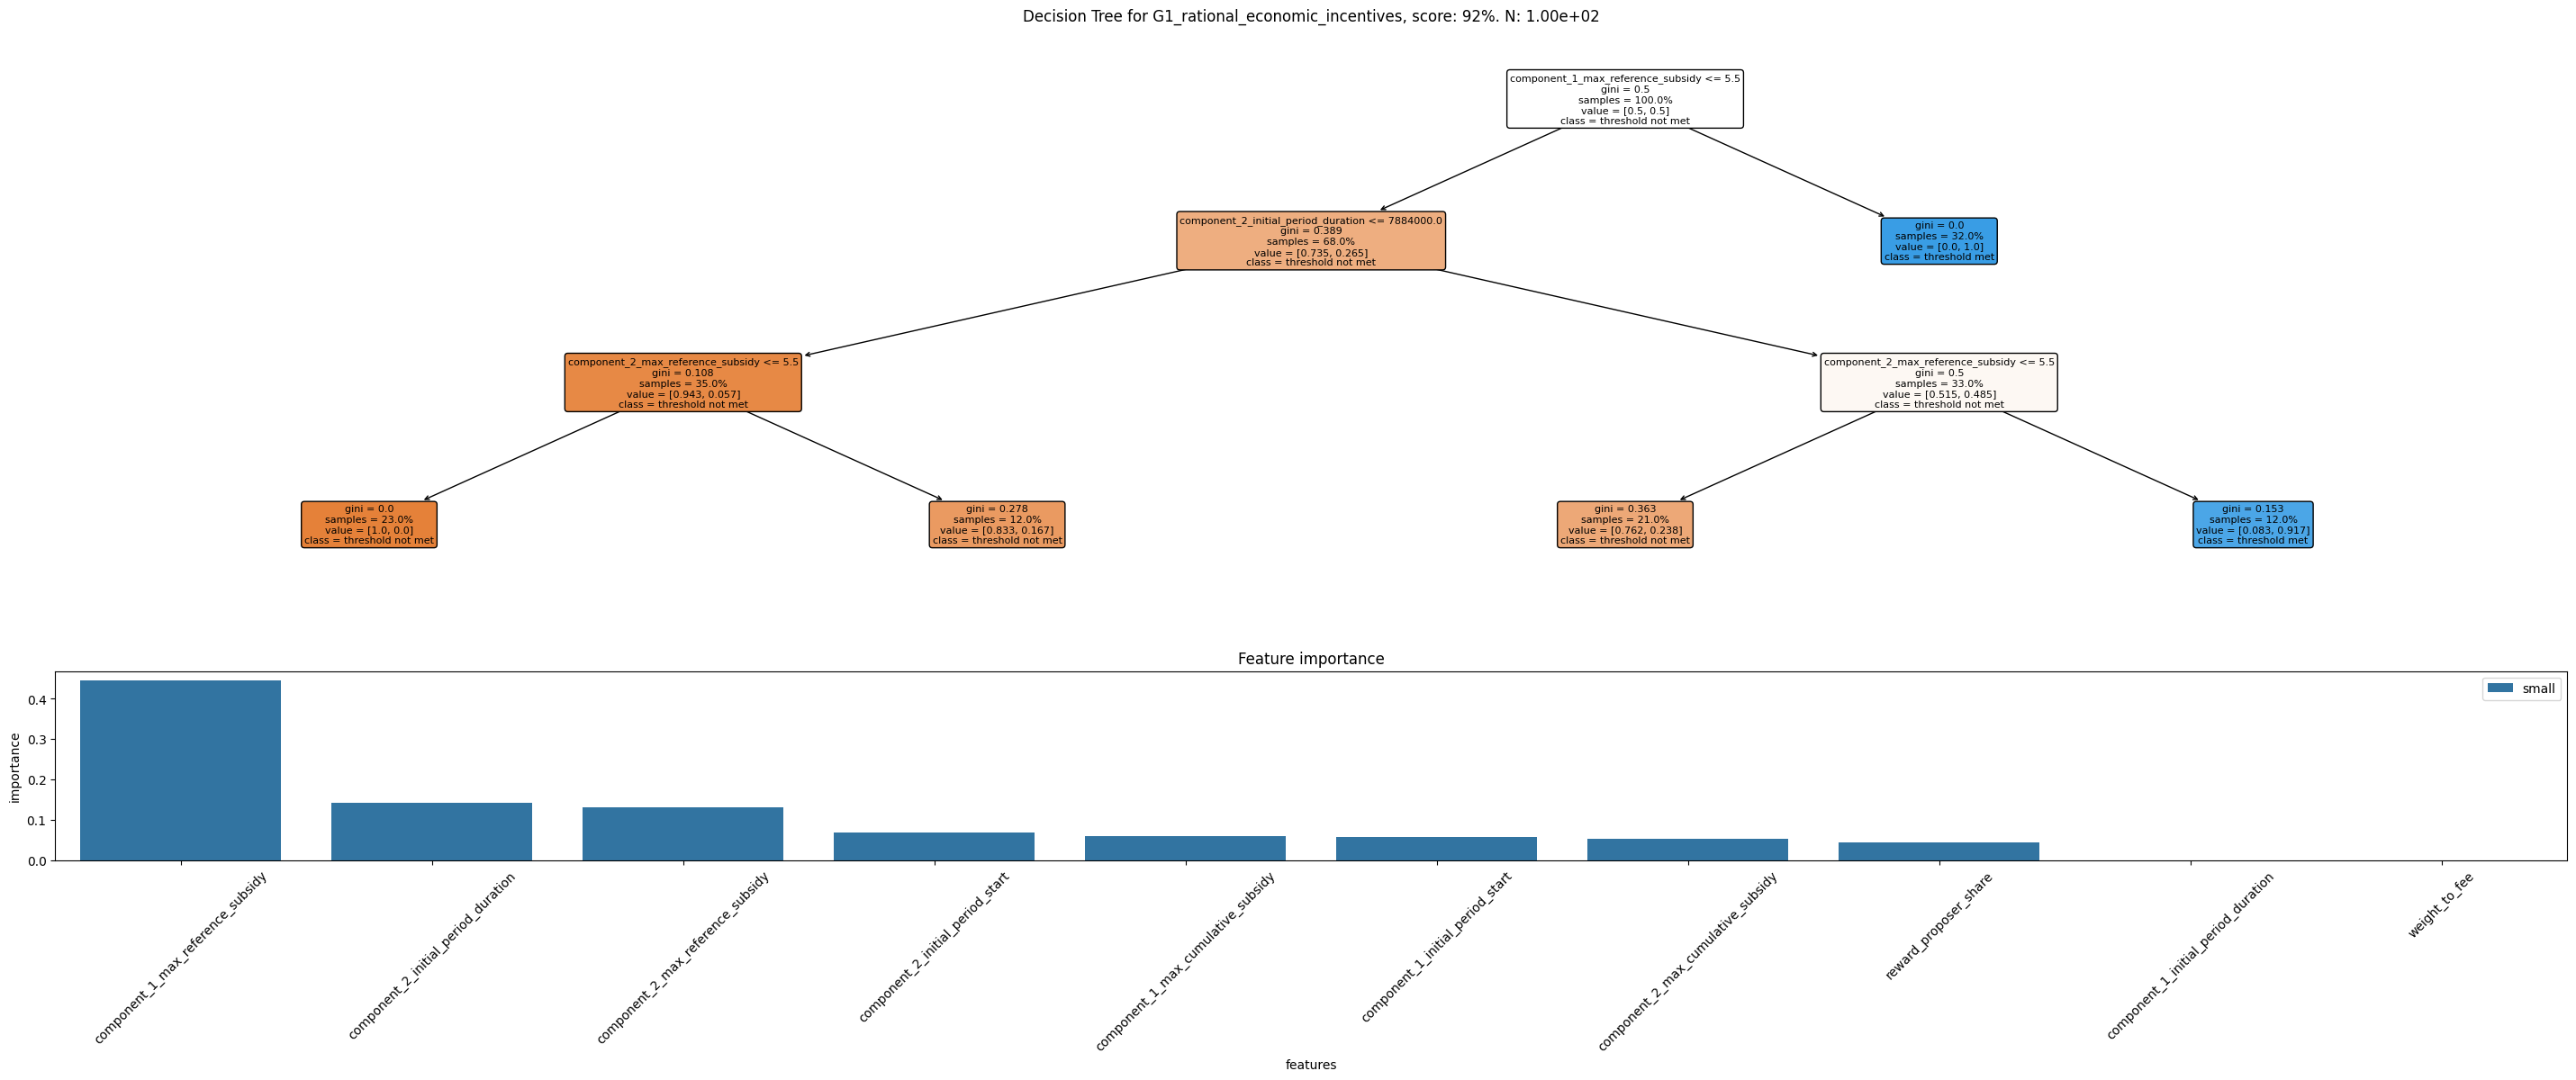

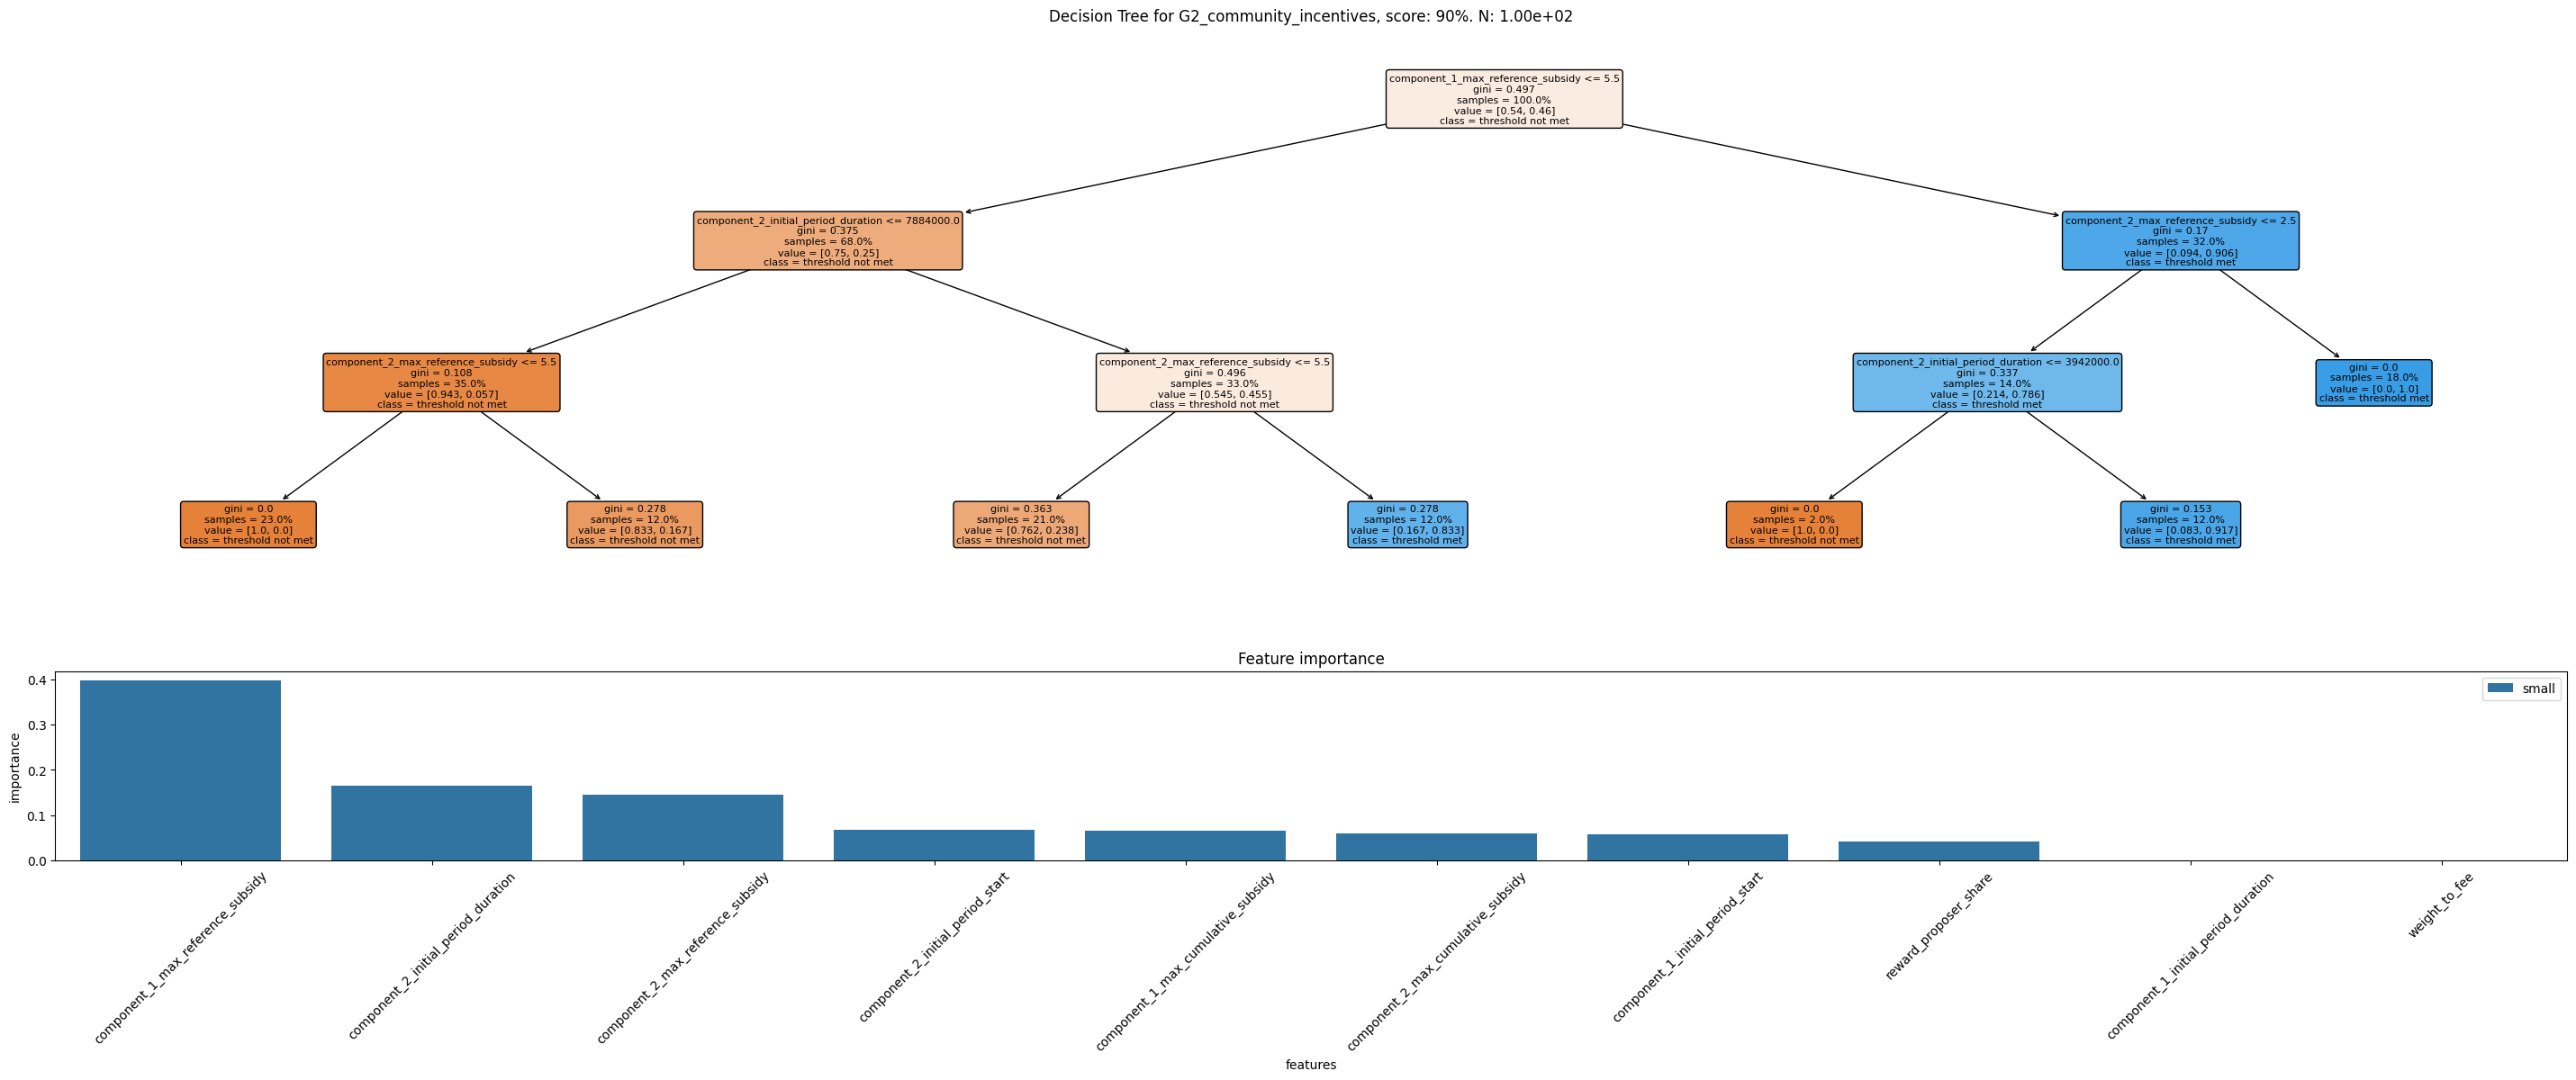

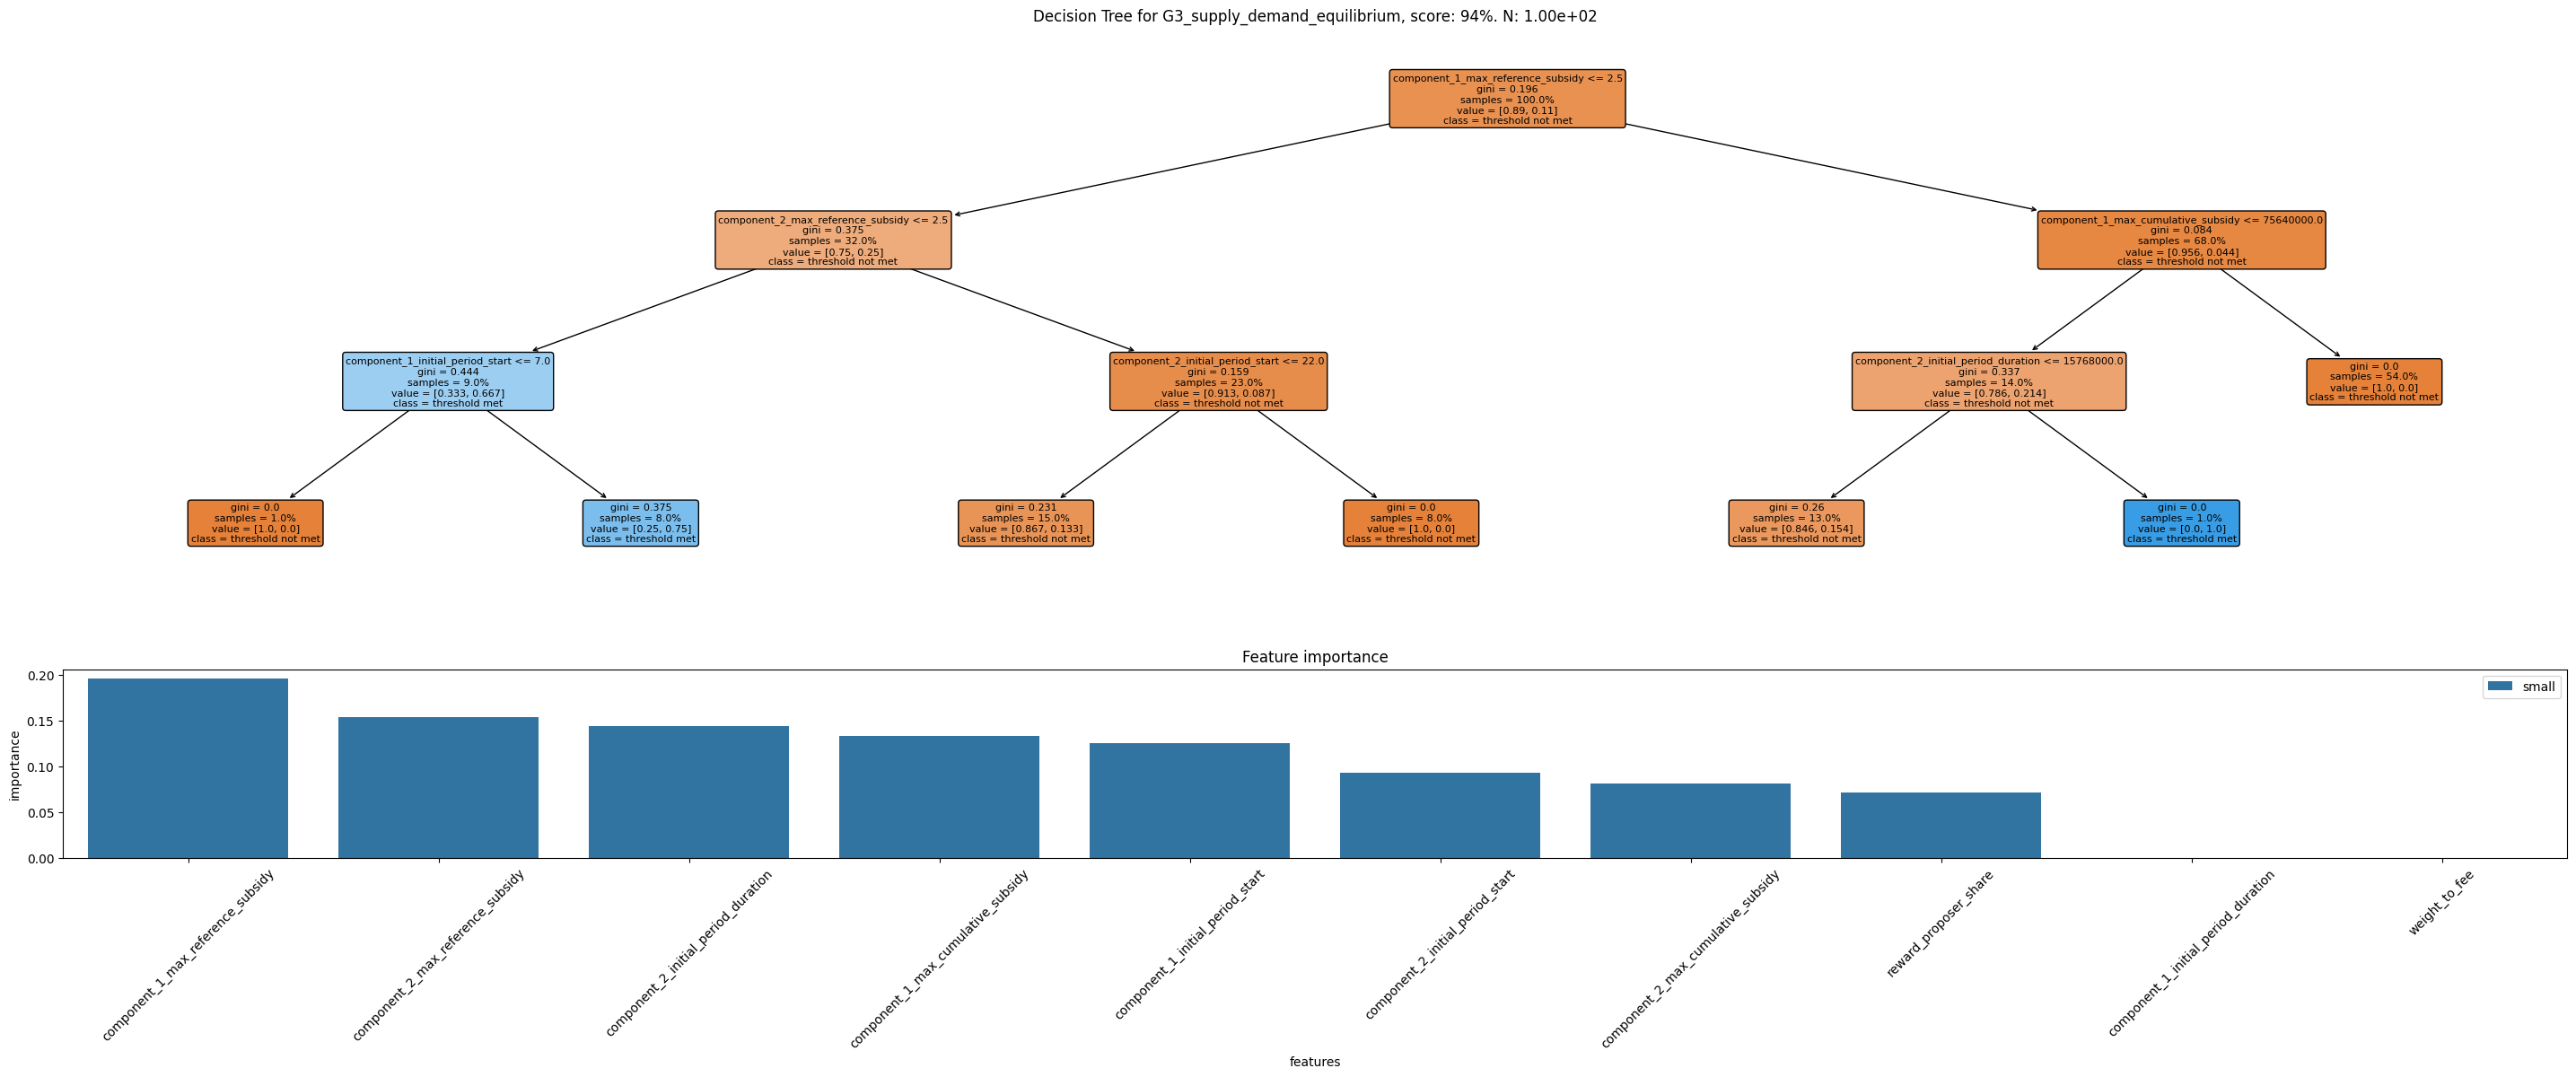

In [8]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

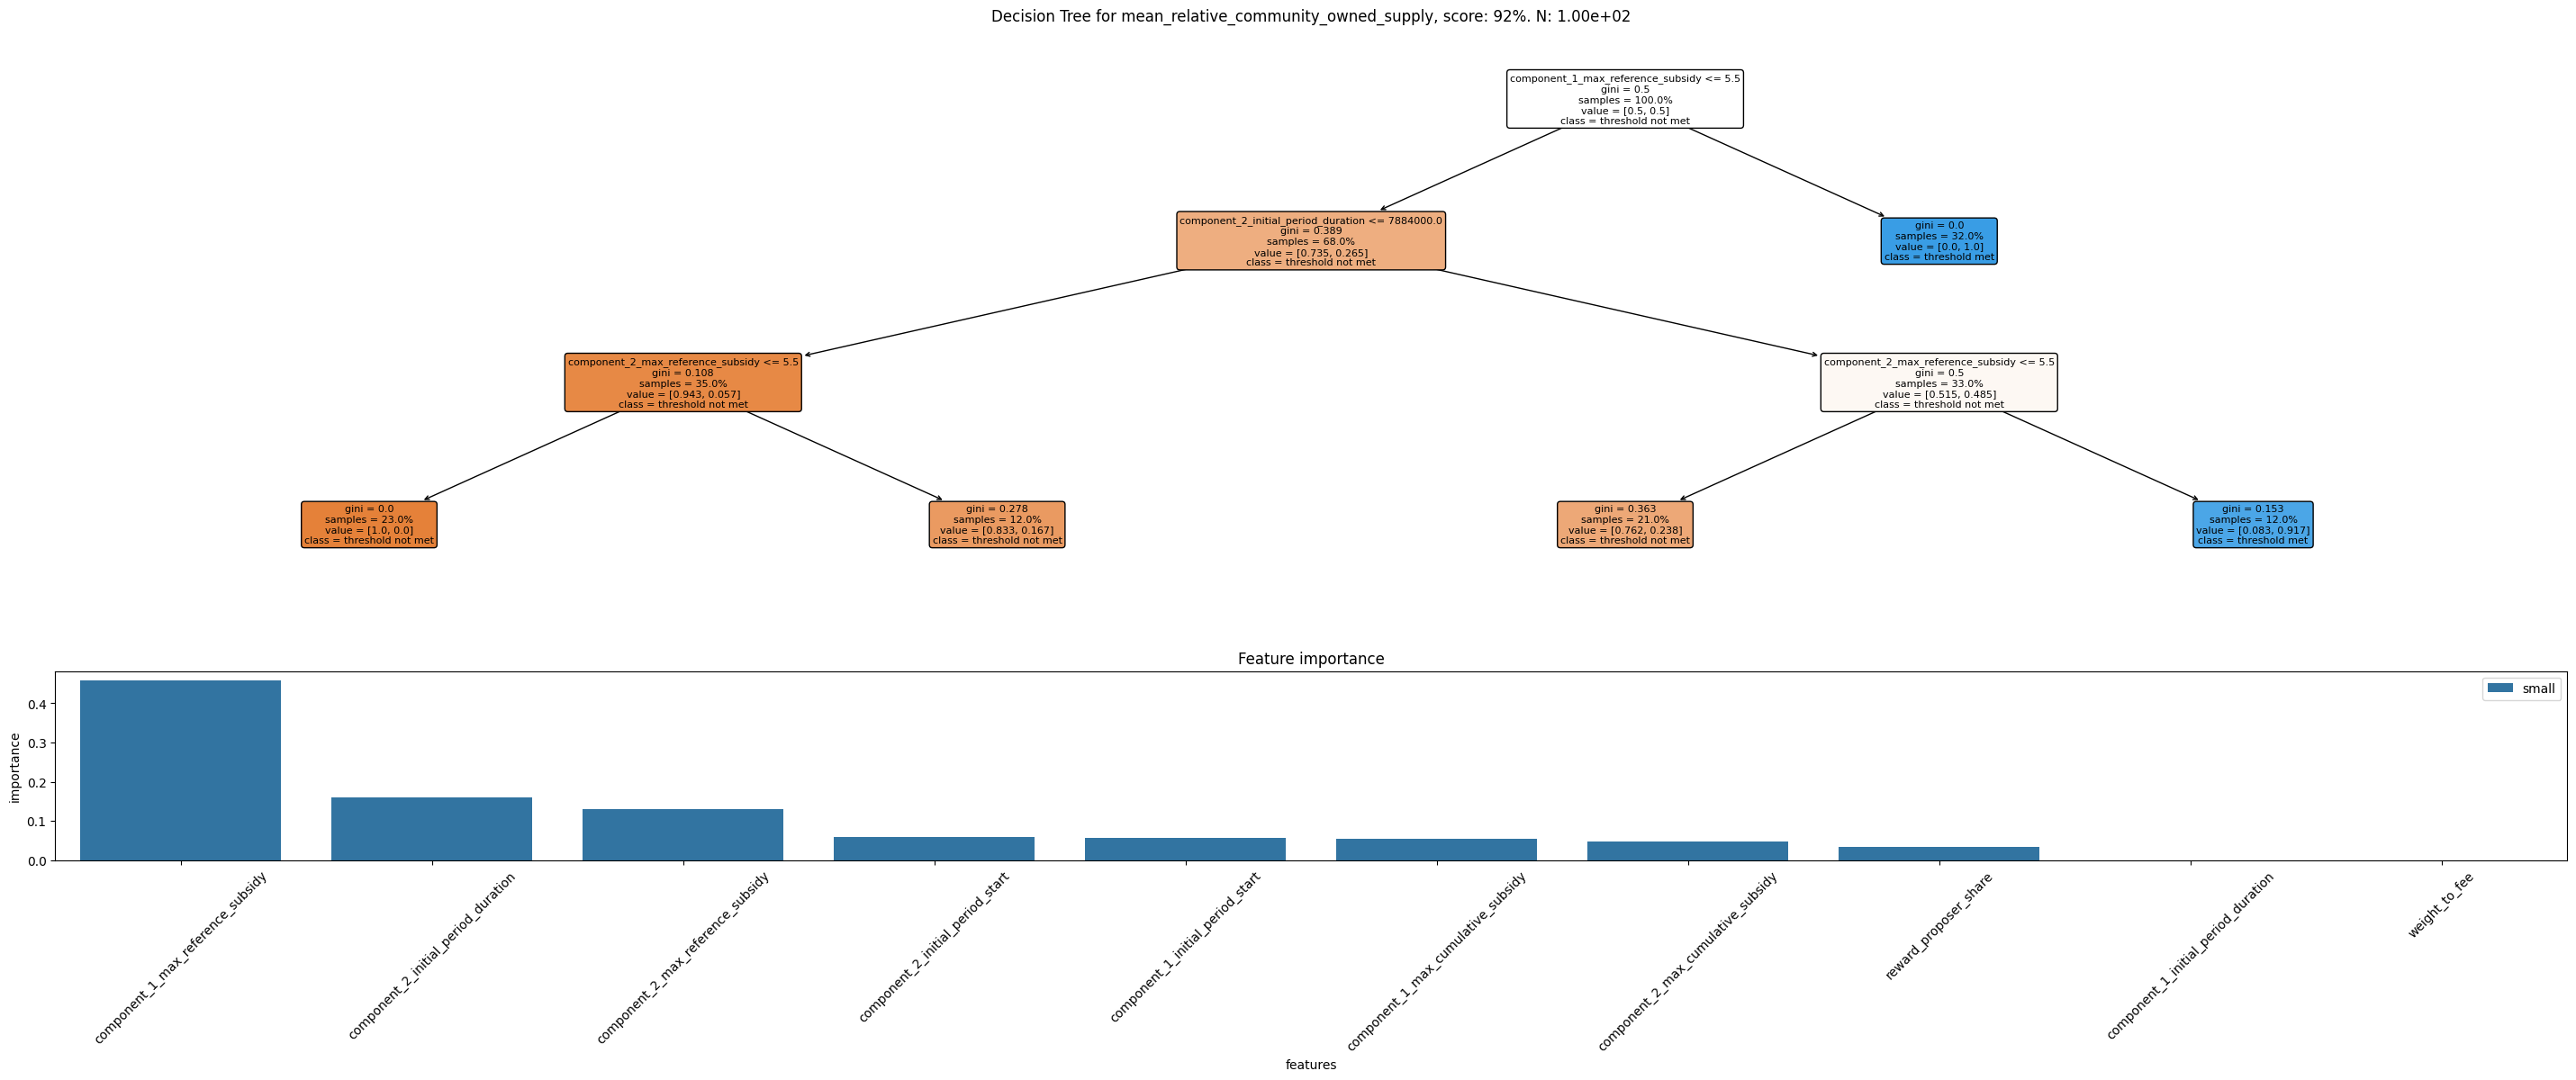

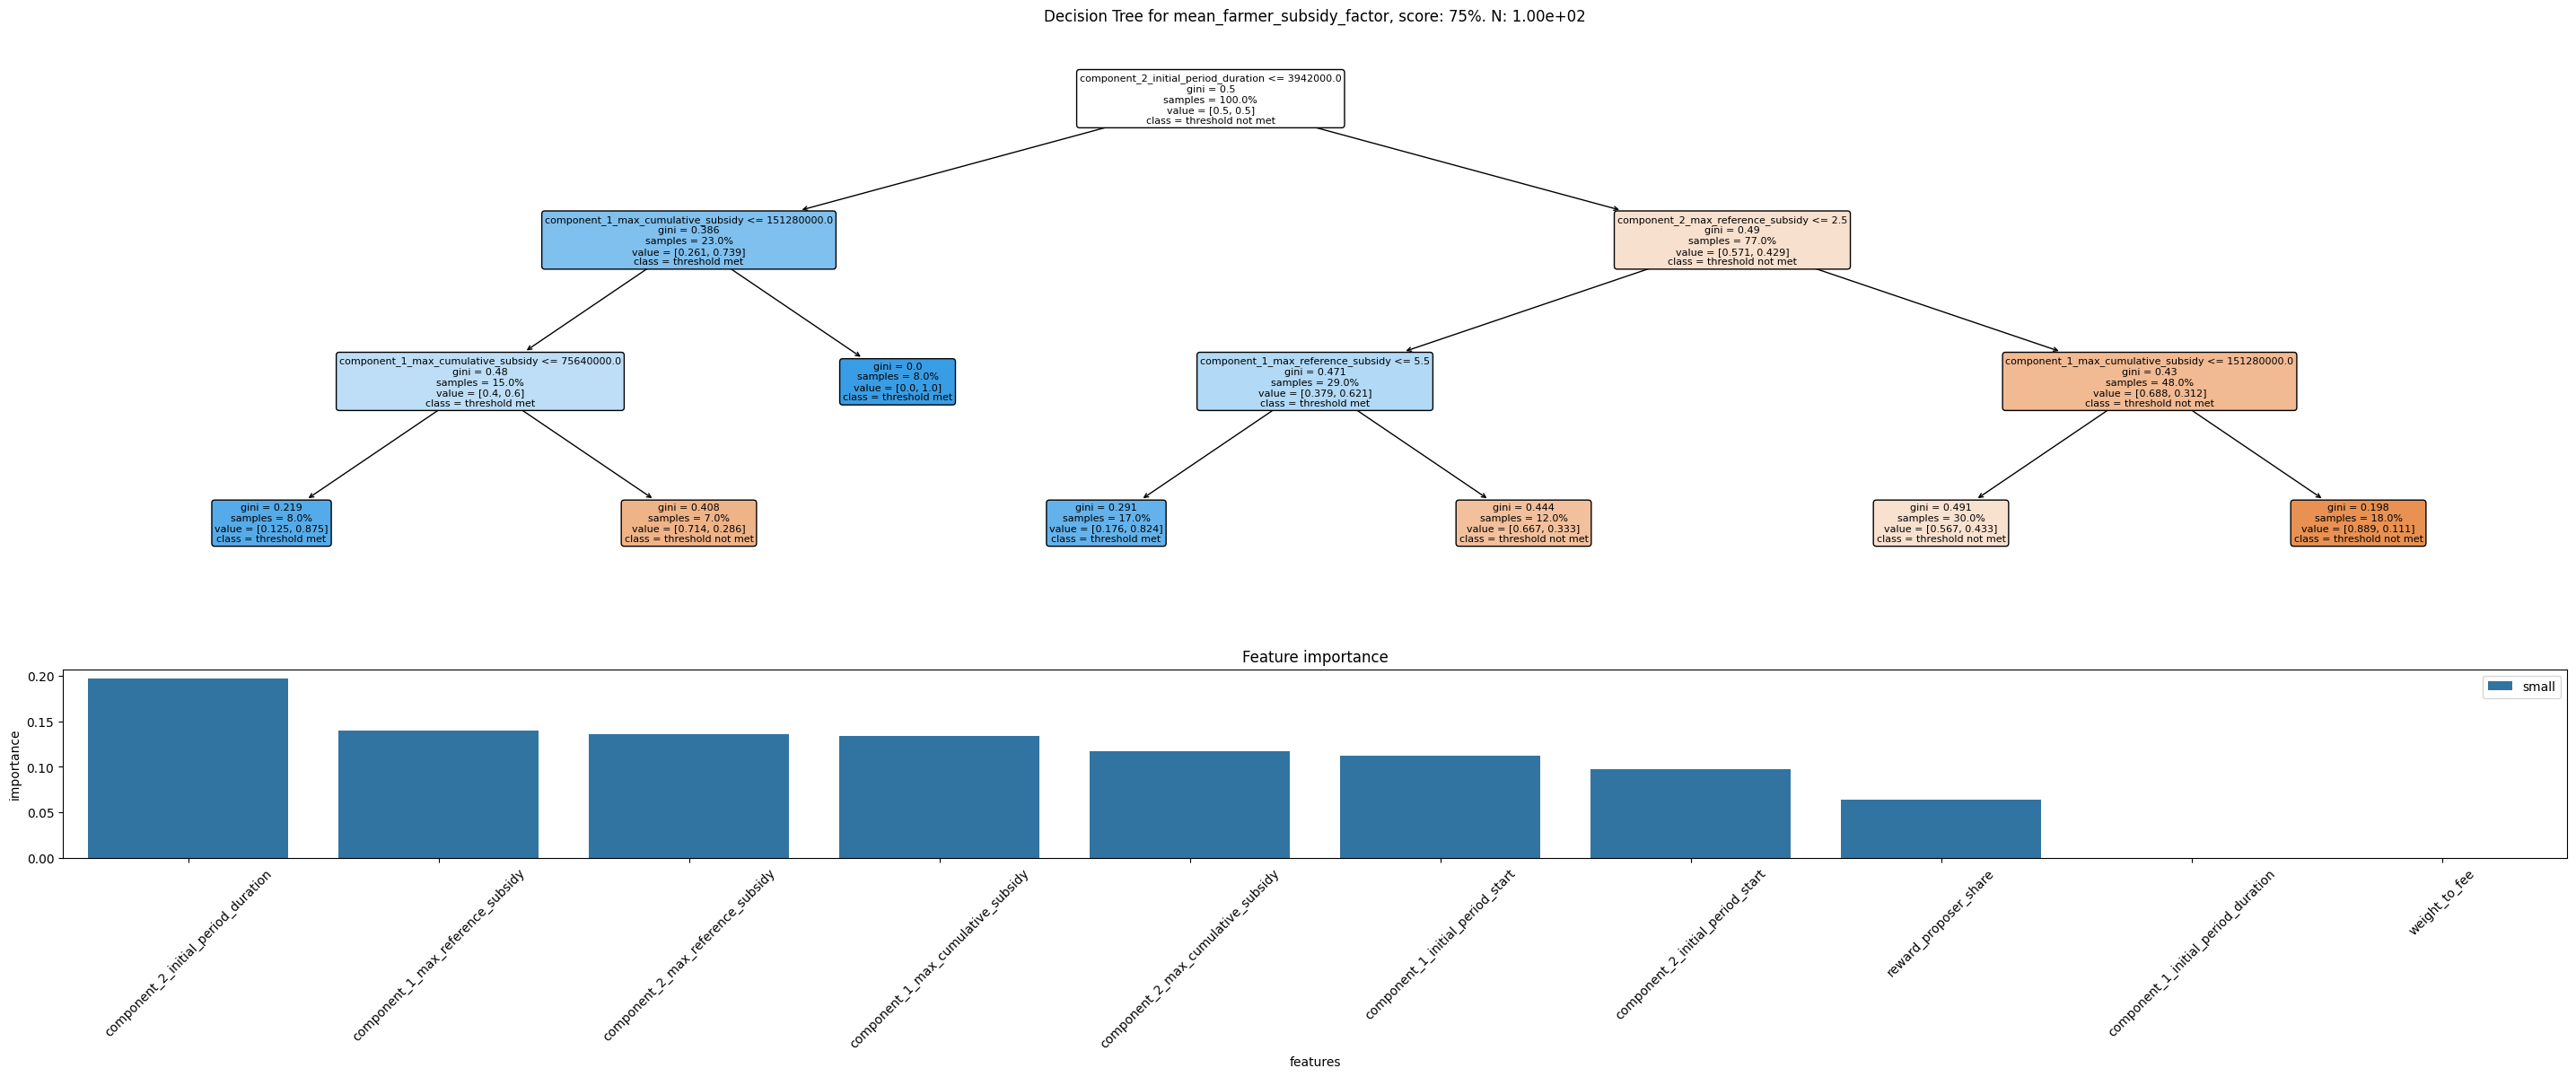

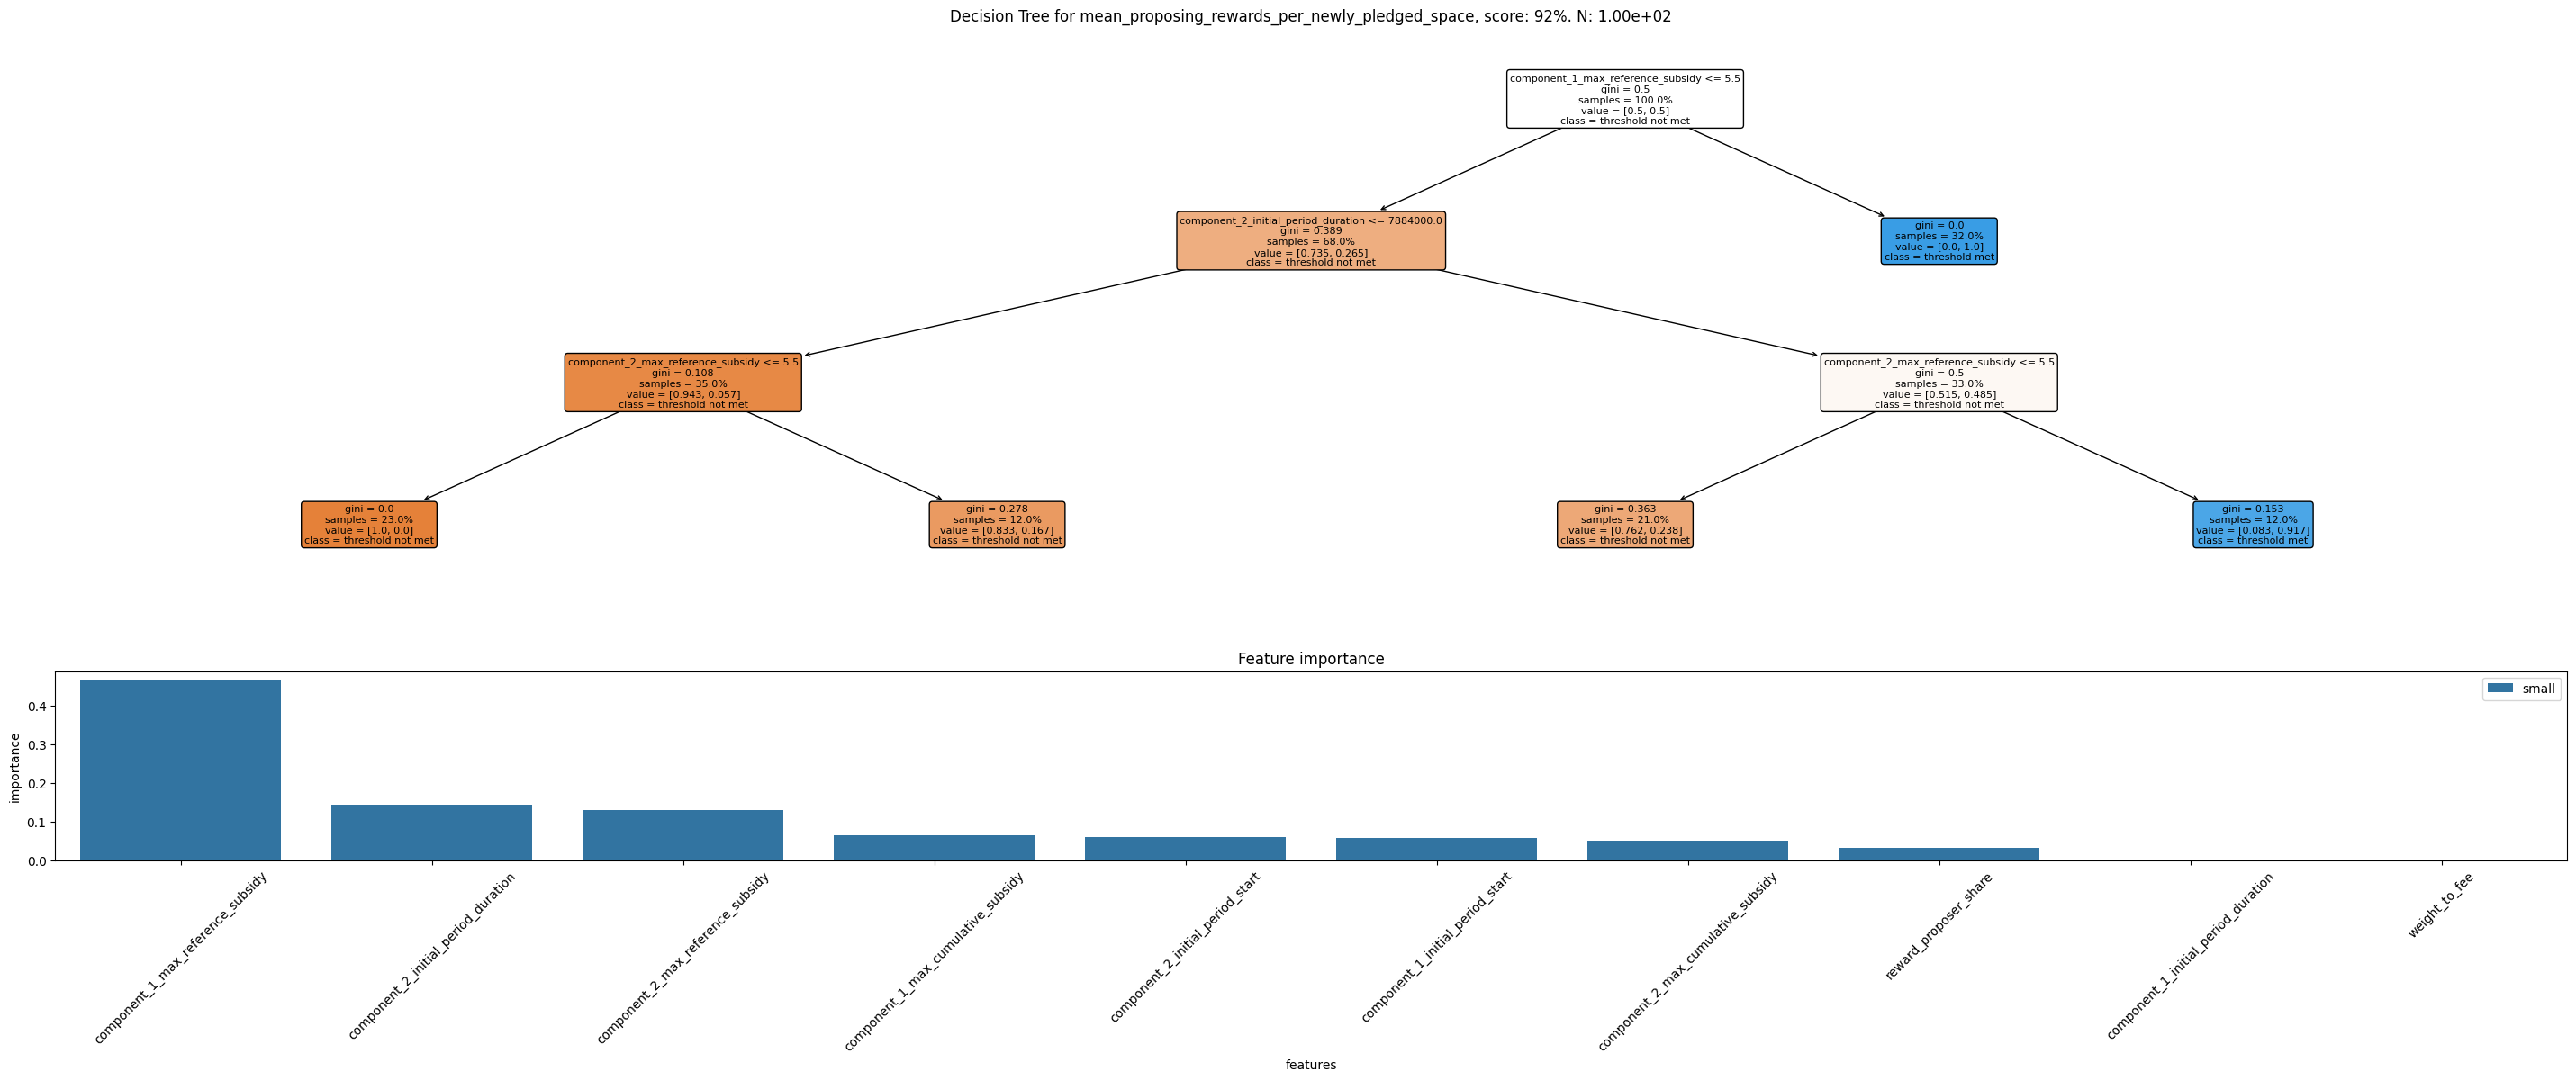

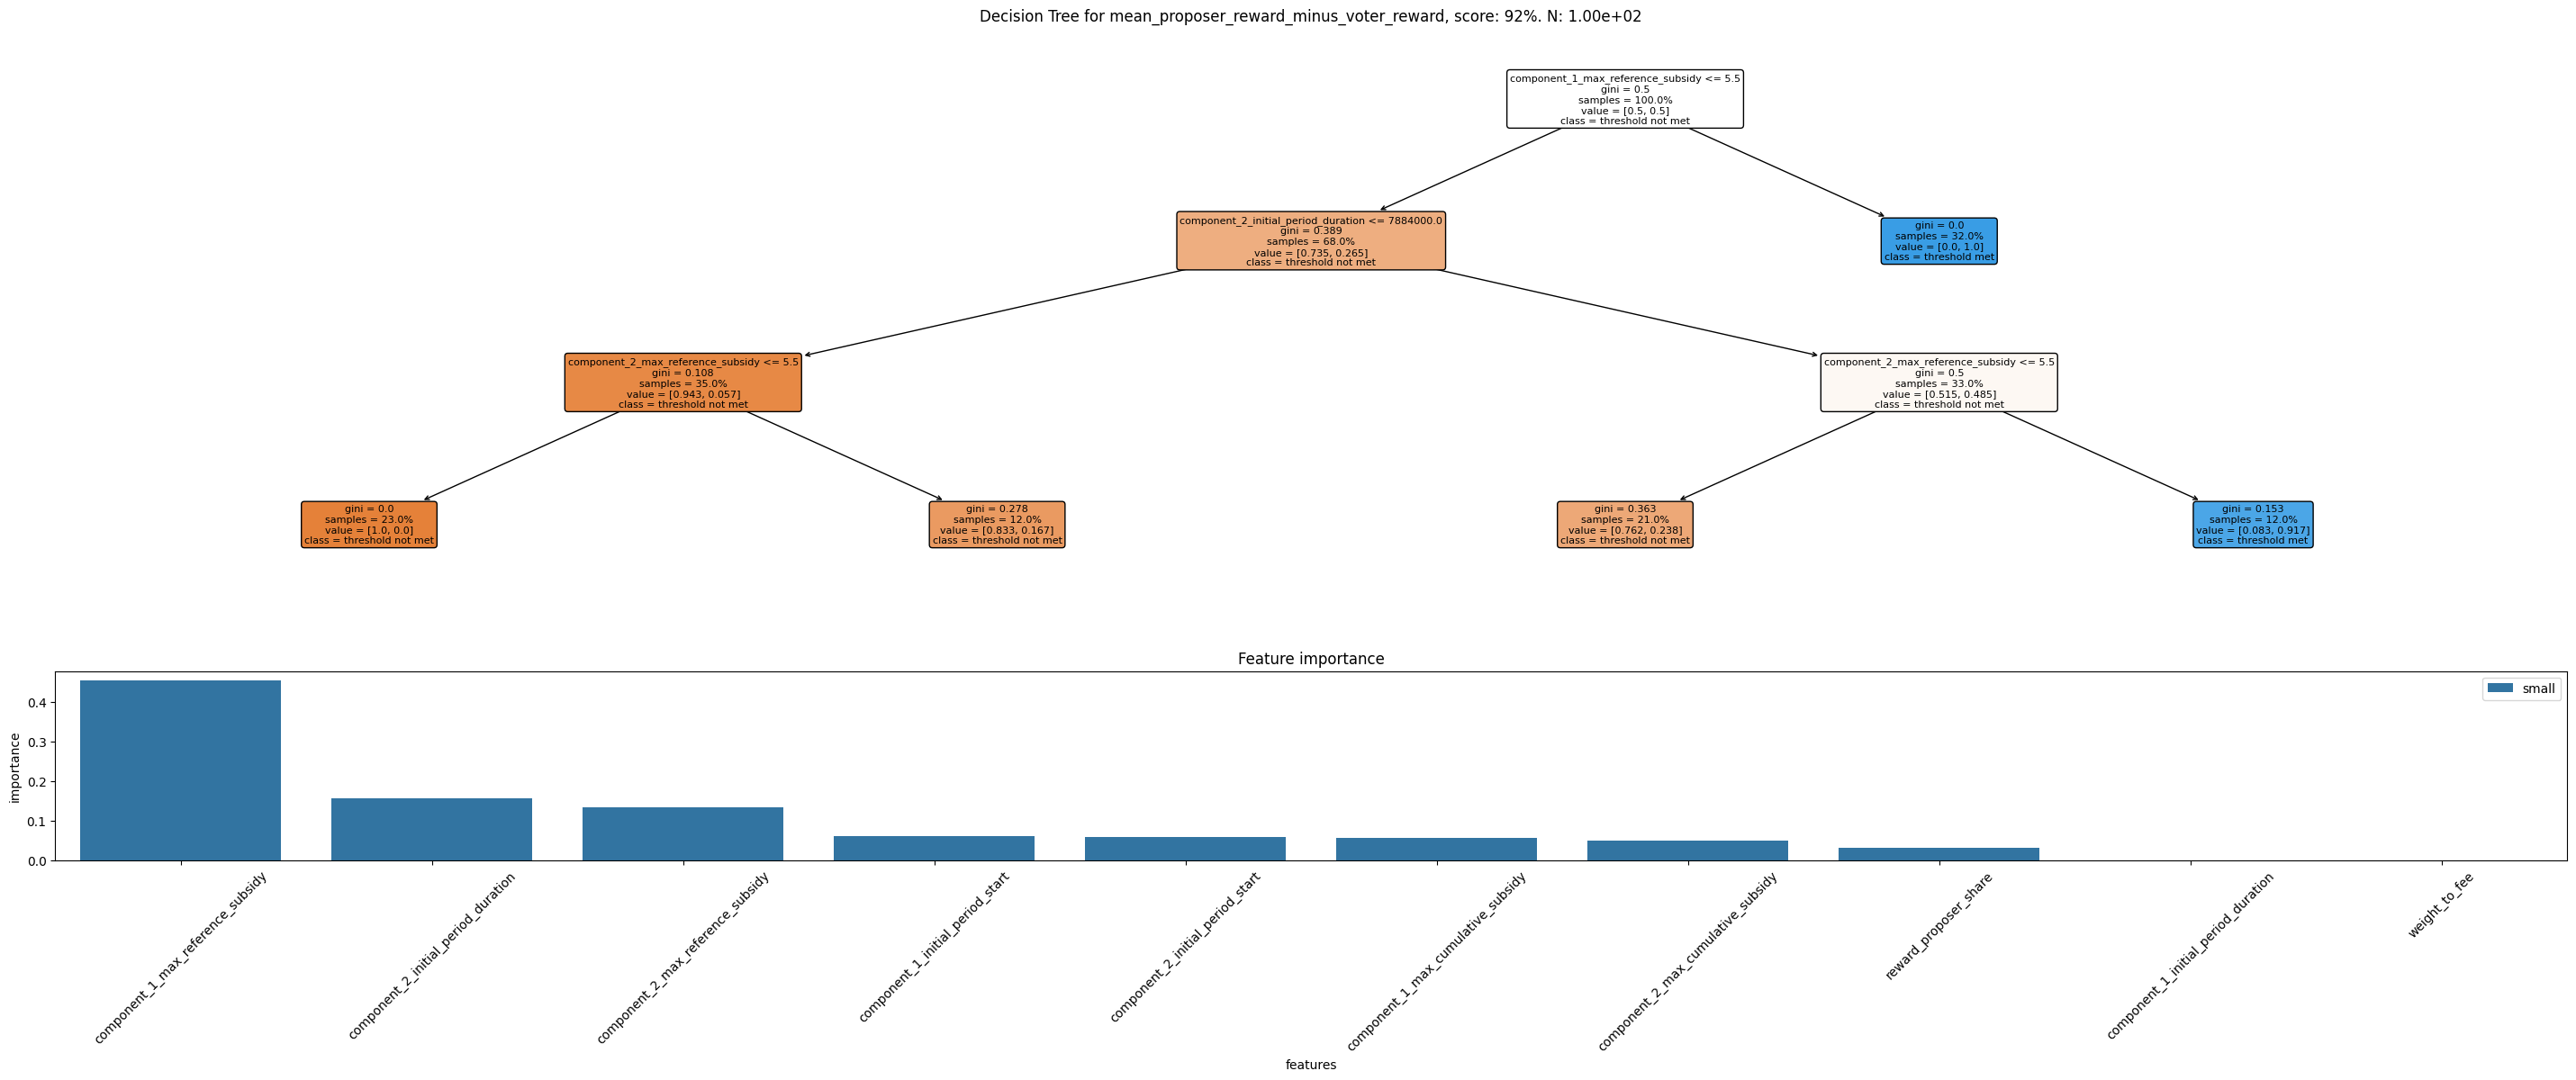

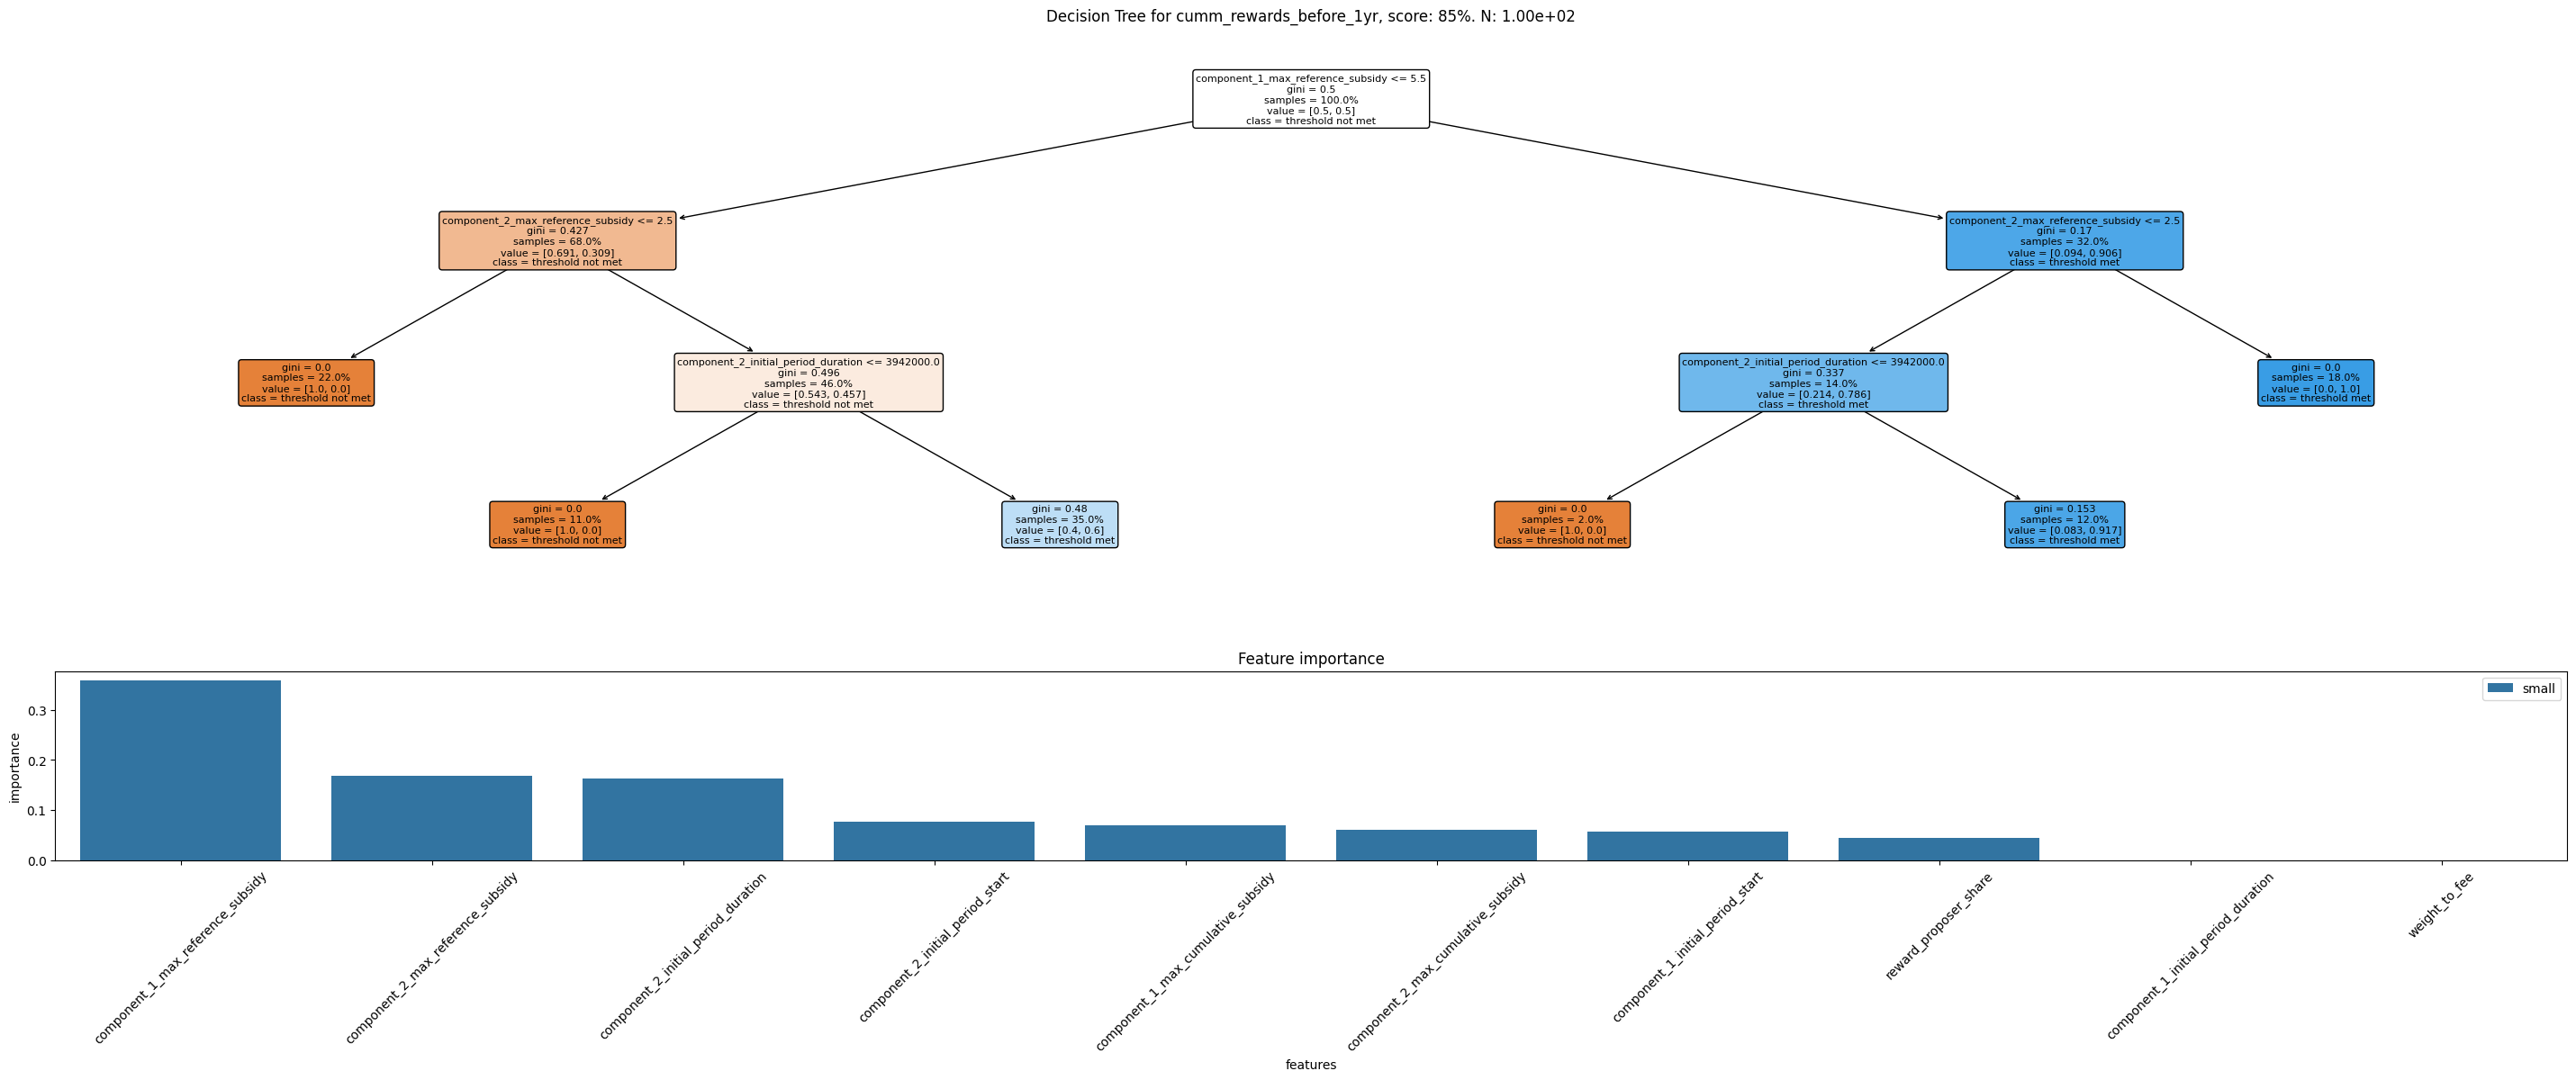

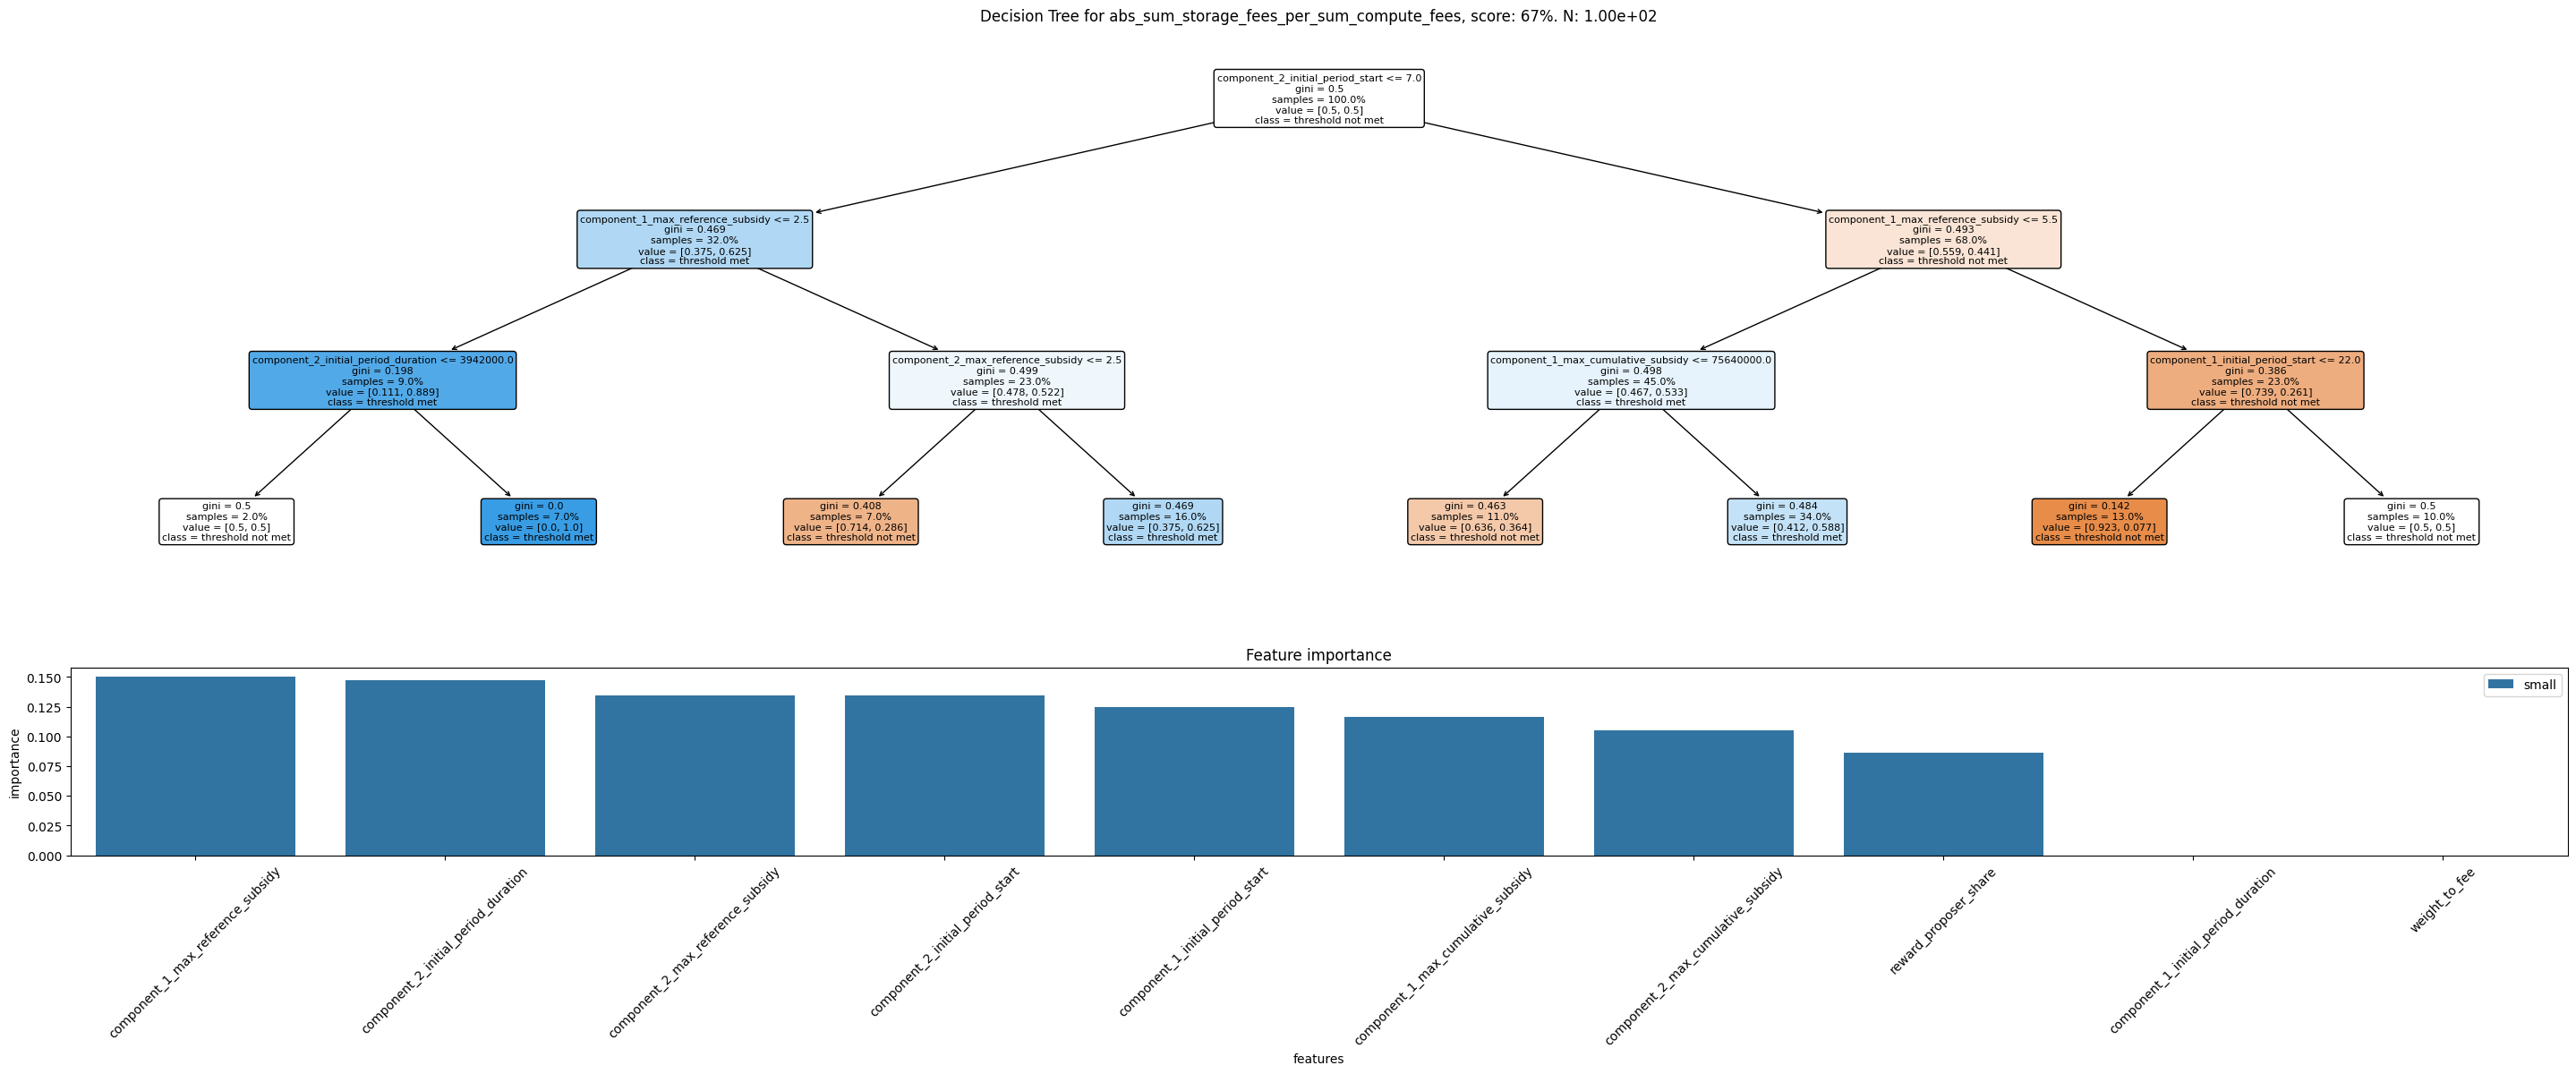

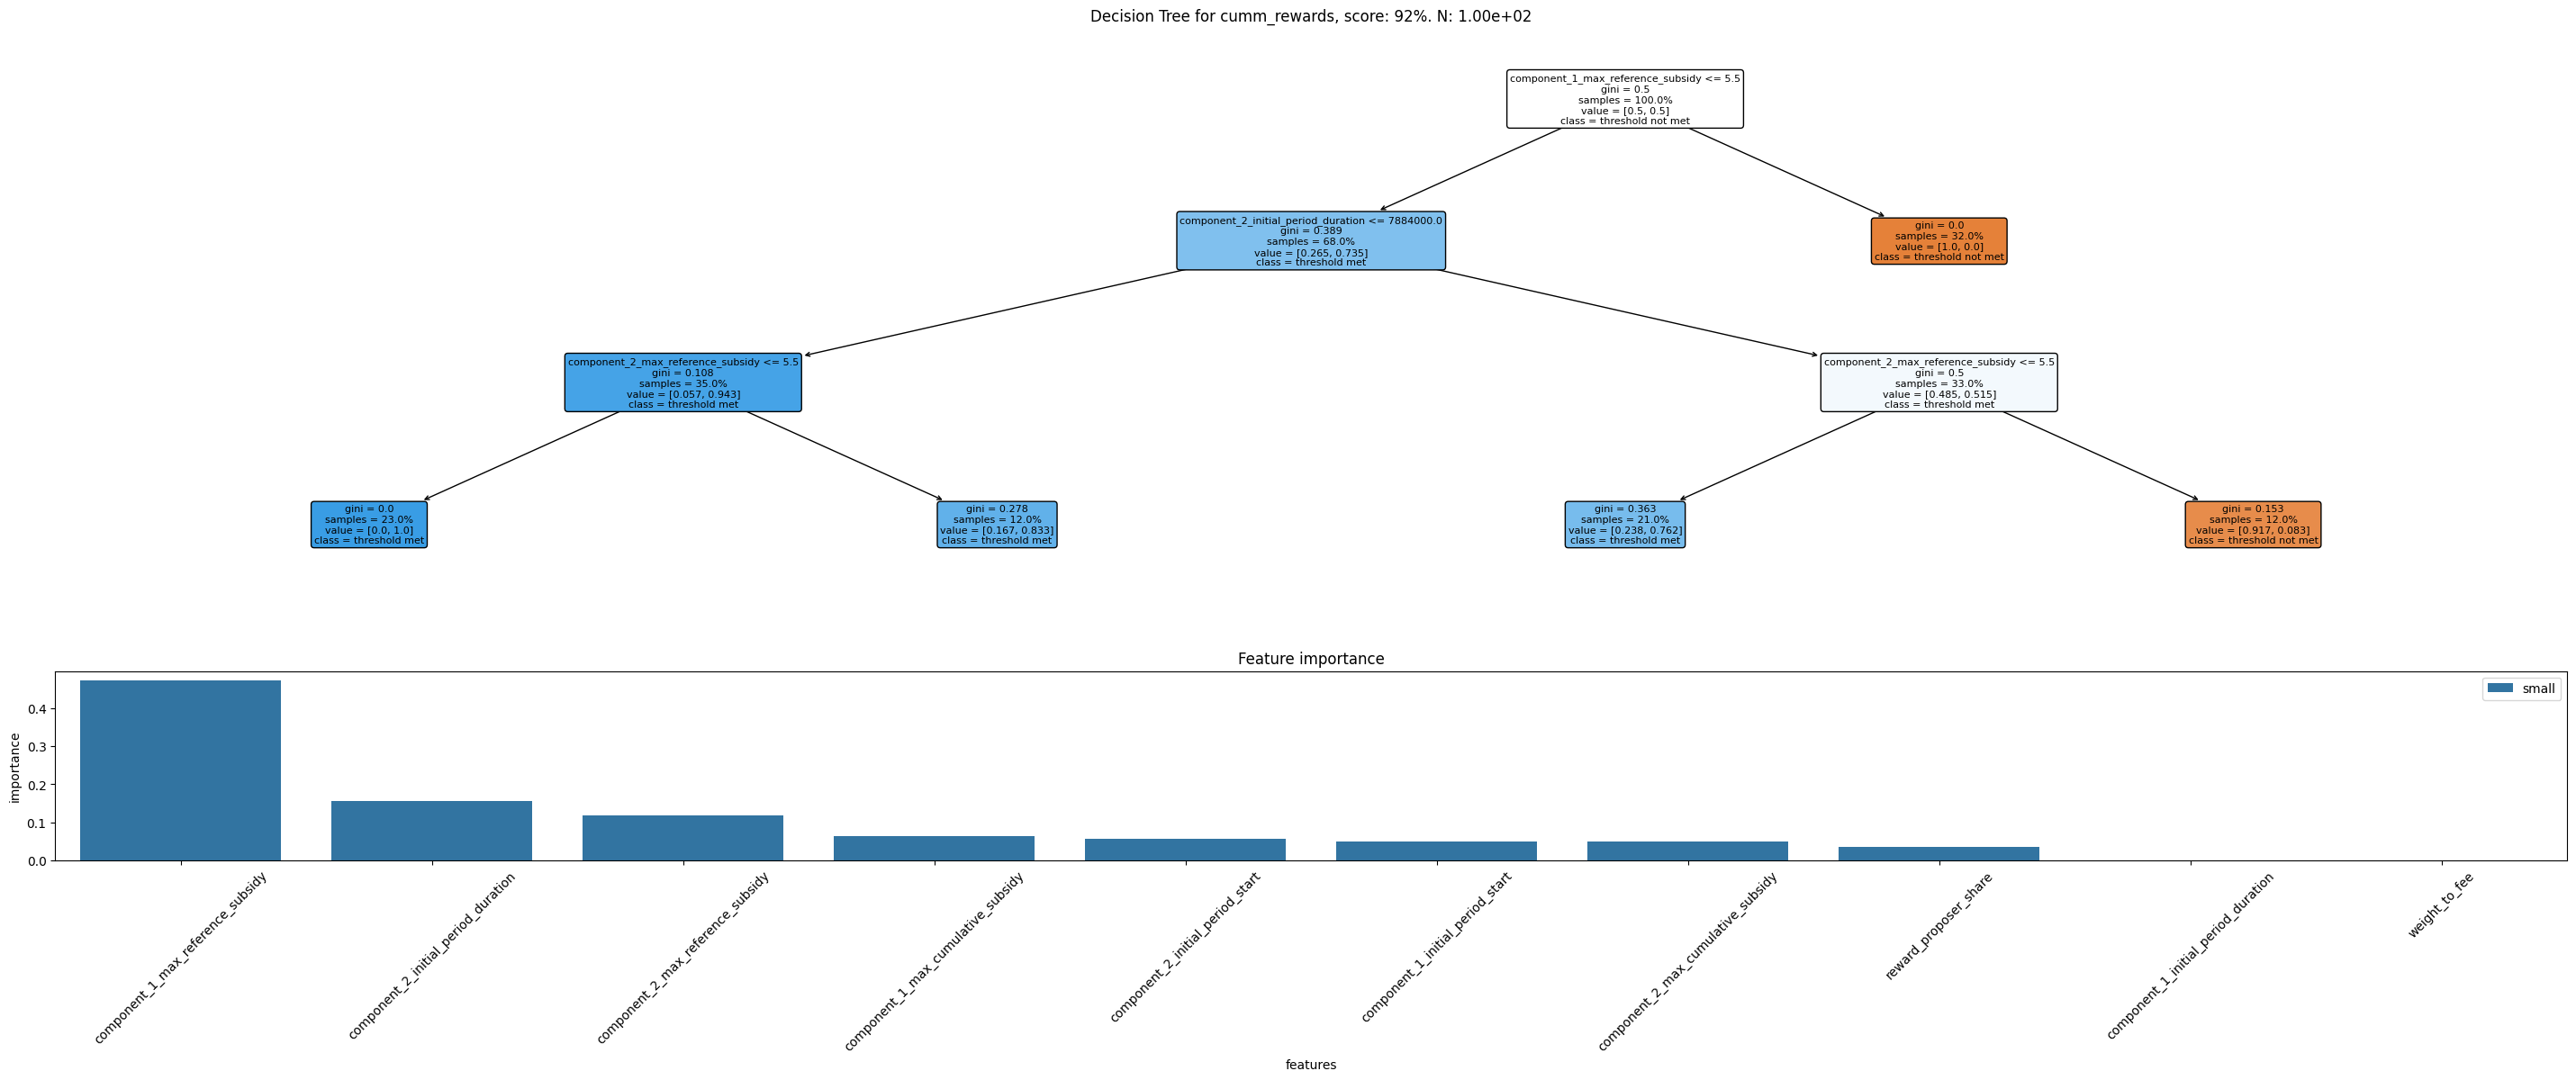

In [9]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

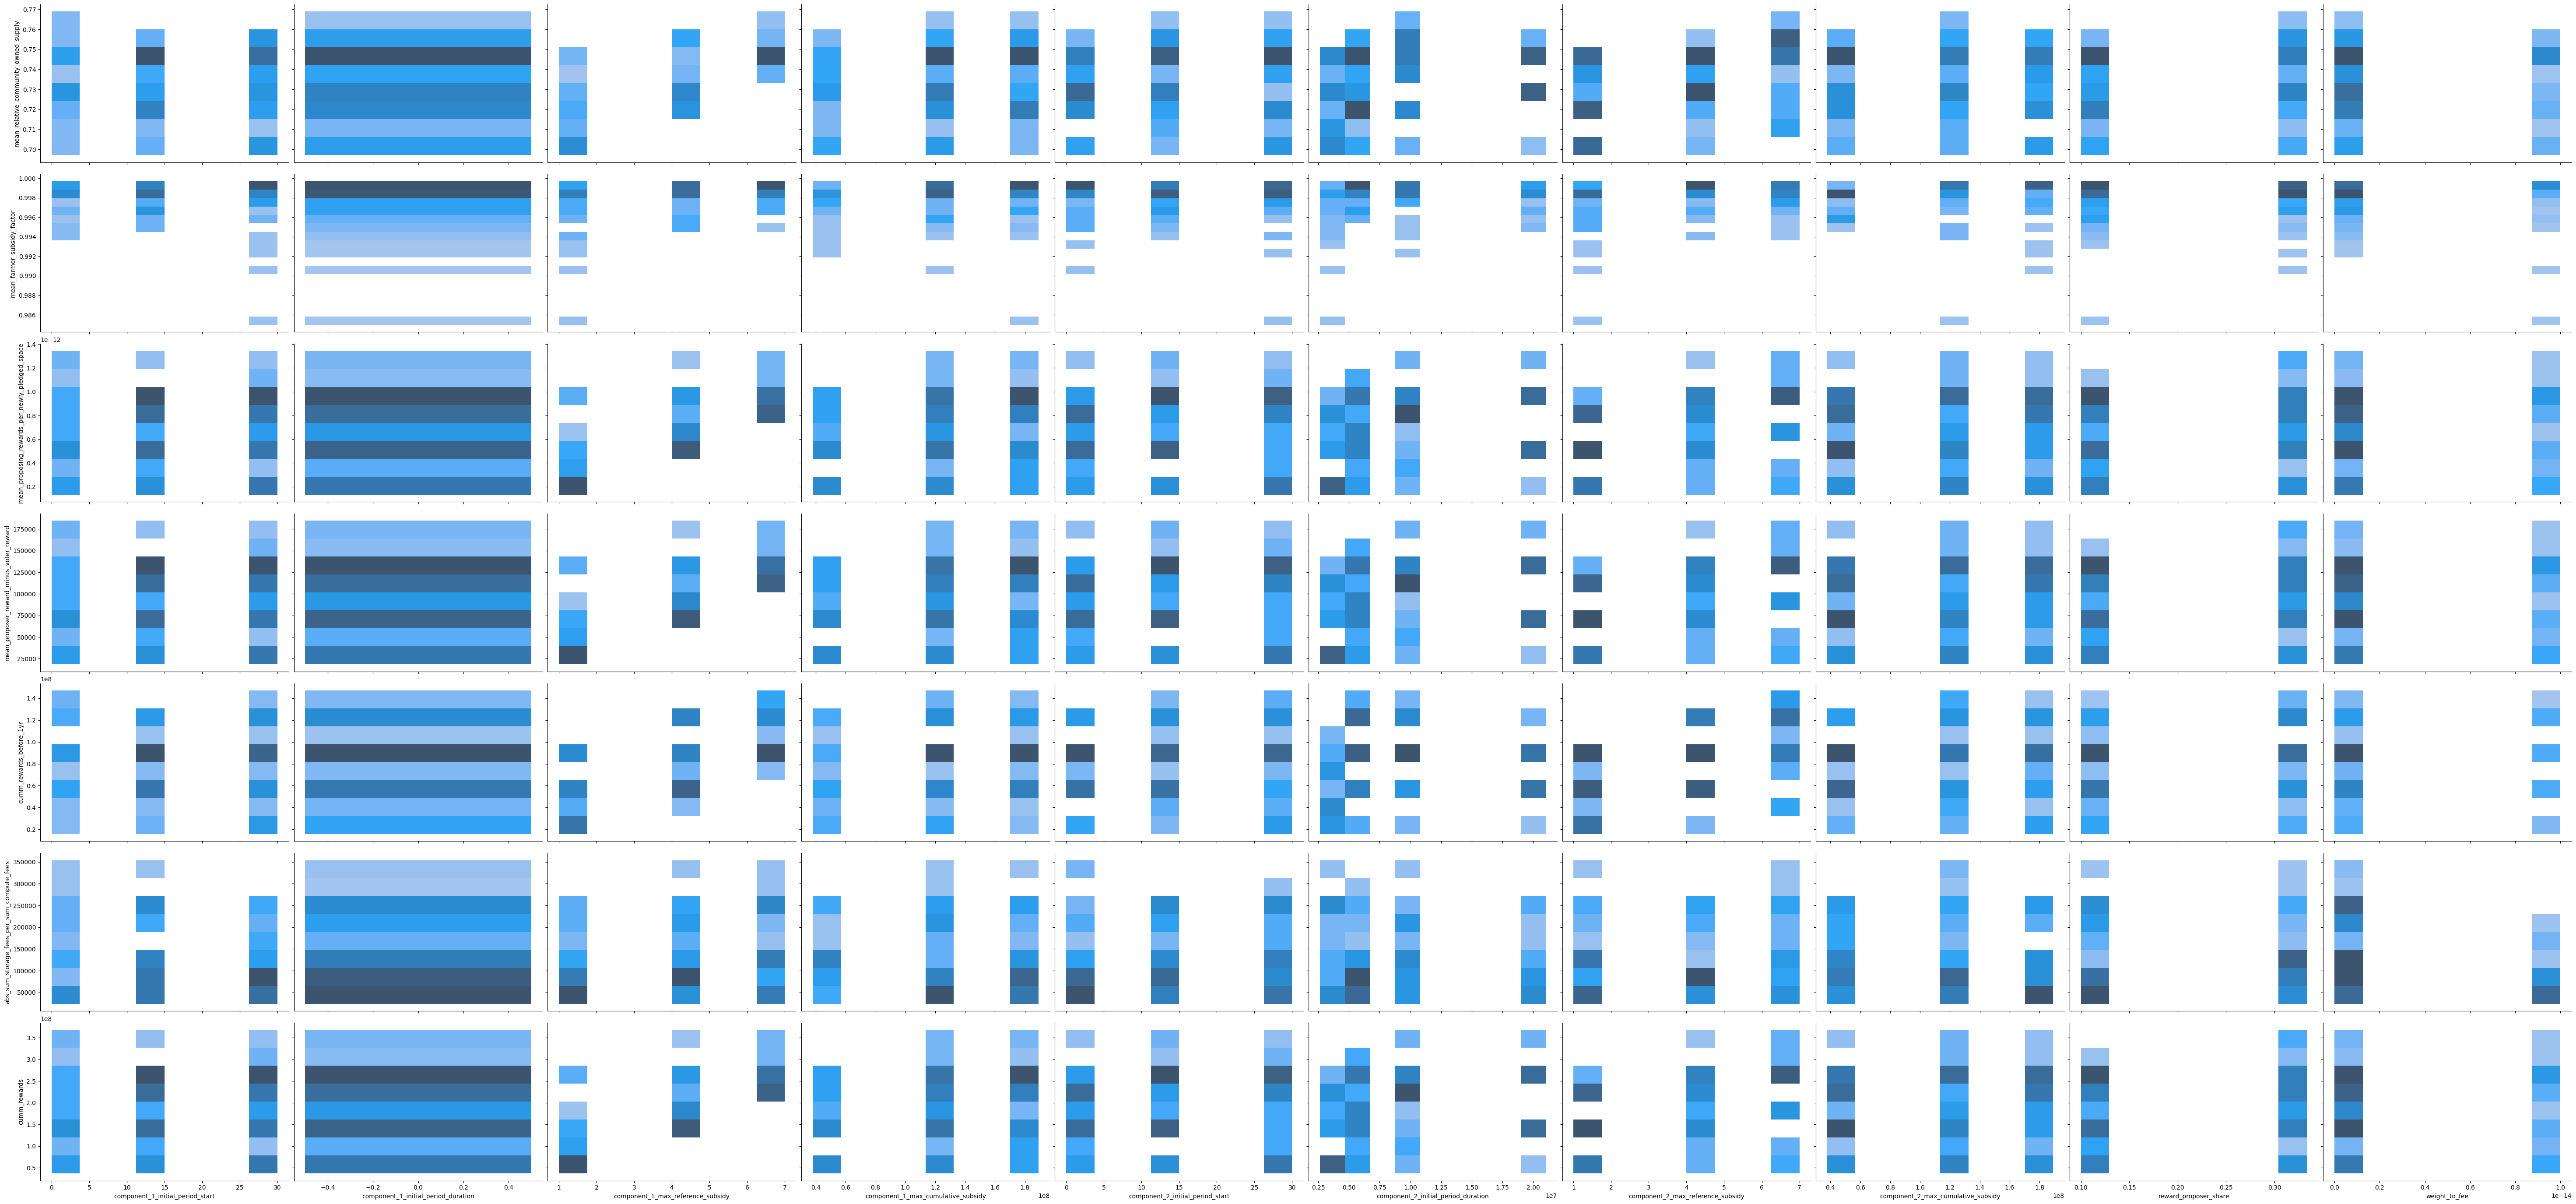

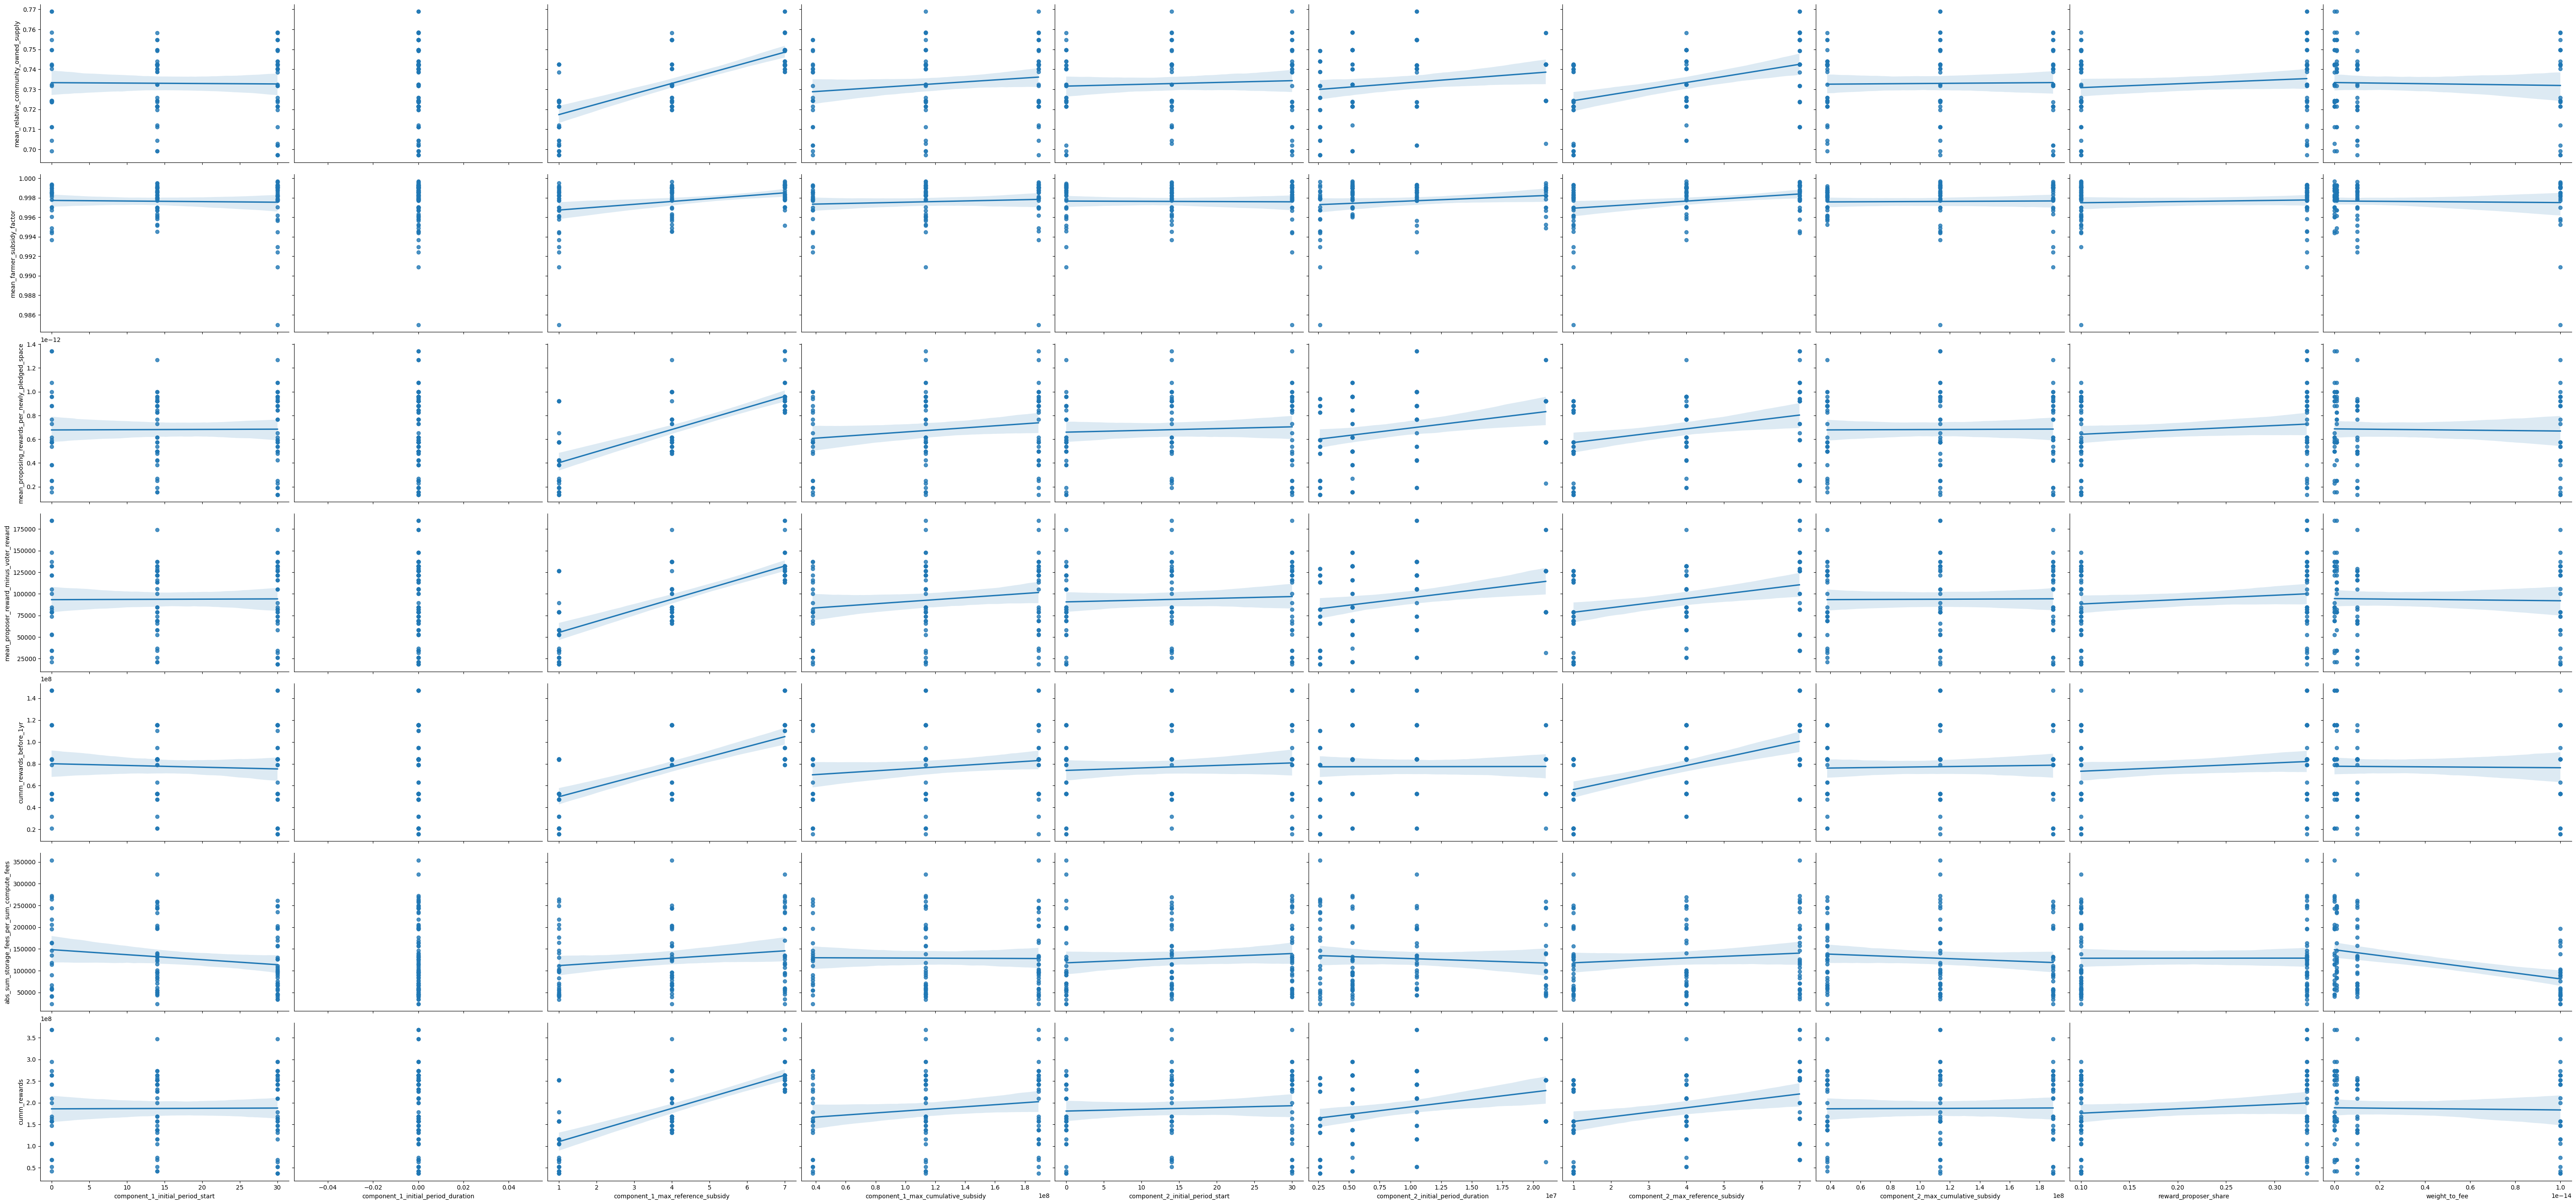

In [10]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [11]:
agg_df

simulation  subset  run  component_1_max_cumulative_subsidy  \
0            0       0    1                         113460000.0   
1            0       1    2                         189100000.0   
2            0       2    3                         189100000.0   
3            0       3    4                         113460000.0   
4            0       4    5                         189100000.0   
..         ...     ...  ...                                 ...   
95           0      75   16                         189100000.0   
96           0      76   17                         189100000.0   
97           0      77   18                         113460000.0   
98           0      78   19                         113460000.0   
99           0      79   20                         113460000.0   

    component_2_initial_period_duration  component_2_max_reference_subsidy  \
0                             5256000.0                                  1   
1                            10512000.0                                  4   
2                            10512000.0                                  1   
3                             5256000.0                                  1   
4                             5256000.0                                  7   
..                                  ...                                ...   
95                           10512000.0                                  7   
96                           10512000.0                                  4   
97                            5256000.0                                  7   
98                           21024000.0                                  1   
99                           21024000.0                                  4   

    component_2_initial_period_start  component_1_initial_period_duration  \
0                                  0                                    0   
1                                  0                                    0   
2                                  0                                    0   
3                                 30                                    0   
4                                 30                                    0   
..                               ...                                  ...   
95                                30                                    0   
96                                 0                                    0   
97                                14                                    0   
98                                14                                    0   
99                                14                                    0   

    component_1_max_reference_subsidy  weight_to_fee  \
0                                   4   1.000000e-18   
1                                   1   1.000000e-14   
2                                   7   1.000000e-15   
3                                   1   1.000000e-18   
4                                   1   1.000000e-14   
..                                ...            ...   
95                                  4   1.000000e-14   
96                                  4   1.000000e-16   
97                                  4   1.000000e-14   
98                                  4   1.000000e-14   
99                                  4   1.000000e-15   

    component_1_initial_period_start  reward_proposer_share  \
0                                 14               0.100000   
1                                 14               0.100000   
2                                 30               0.333333   
3                                  0               0.100000   
4                                  0               0.100000   
..                               ...                    ...   
95                                30               0.333333   
96                                30               0.100000   
97                                 0               0.100000   
98                                

In [12]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

In [13]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              7.329736e-01
mean_farmer_subsidy_factor                        9.976222e-01
mean_proposing_rewards_per_newly_pledged_space    6.819052e-13
mean_proposer_reward_minus_voter_reward           9.375143e+04
cumm_rewards_before_1yr                           7.737682e+07
abs_sum_storage_fees_per_sum_compute_fees         1.285680e+05
cumm_rewards                                      1.869915e+08
Name: mean, dtype: float64

In [14]:
d['std'] / d['mean']

mean_relative_community_owned_supply              0.023818
mean_farmer_subsidy_factor                        0.002145
mean_proposing_rewards_per_newly_pledged_space    0.443433
mean_proposer_reward_minus_voter_reward           0.443433
cumm_rewards_before_1yr                           0.423643
abs_sum_storage_fees_per_sum_compute_fees         0.608421
cumm_rewards                                      0.443433
dtype: float64